# Element based system

NN model takes (1, 151) input sample and outputs (1, 6) array of 6 h width values and (1, 5) array of element-encoded configuration. The sphere element structure is defined by the network as well as the width design.

Input (1, 151) - absorbed power sampled over visible spectrum (from 400 to 700 nm)

Output (1, 6) - sphere layer deisgn [h1, h2, h3, h4, h5, h6] and (1, 5) encoded element configuration

NN model consists of 11 layers (5 hidden + 6 parallel ouput)

Batch normalization layers, dropout (60%), and LeakyReLU

Evaluation metrics: RMSE and MAE for regression and Cross Entropy Loss and Accuracy for classification

K-fold cross validation

Adam optimizer with He-Xavier initial weights

Learning rate array [0.0001, 0.001, 0.01]

Number of neurons per layer array [100, 200, 300, 400, 500, 600]

Early stopping criteria is used

In [13]:
import pandas as pd
import numpy as np
import torch
from torch import nn
import torch.optim as optim
import sys
import statistics as st
import copy
from sklearn.model_selection import KFold
import argparse
from torch.utils.data.dataset import random_split
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torchsummary import summary
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler

In [4]:
# CUDA check

device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
print(device)

cuda:0


In [88]:
# dataset import and training flag selection

data_distribution = "Normal"
#data_distribution = "Uniform"

data_normalized_flag = False
includes_source_distance = True
polarization_mode = "TE"

pd_x_train_val_ger = pd.read_csv('./Element_based_data/fixed/element_based_data_h6_fixed/normal/germanium_core/X_train_oneHotEncoded.csv', header=None);
pd_y_train_val_ger = pd.read_csv('./Element_based_data/fixed/element_based_data_h6_fixed/normal/germanium_core/y_train_te.csv', header=None);

pd_x_train_val_silv = pd.read_csv('./Element_based_data/fixed/element_based_data_h6_fixed/normal/silver_core/X_train_oneHotEncoded.csv', header=None);
pd_y_train_val_silv = pd.read_csv('./Element_based_data/fixed/element_based_data_h6_fixed/normal/silver_core/y_train_te.csv', header=None);

#pd_ym_train_val = pd.read_csv('./Data/y_train_tm.csv', header=None);

In [89]:
# from pandas to numpy

X_ger = np.array(pd_x_train_val_ger)
y_ger = np.array(pd_y_train_val_ger)

X_silv = np.array(pd_x_train_val_silv)
y_silv = np.array(pd_y_train_val_silv)

In [90]:
# concatenation of dataset of different core elements

X_merged = np.concatenate((X_ger, X_silv), axis = 0)
y_merged = np.concatenate((y_ger, y_silv), axis = 0)

In [91]:
# distirbuting X array to h values and element type

X_h = X_merged[:,0:6]
X_element = X_merged[:,6:11]
X_h = X_h*(10**9)

In [92]:
X_element

array([[0., 1., 0., 1., 0.],
       [0., 1., 0., 1., 0.],
       [0., 1., 0., 1., 0.],
       ...,
       [1., 0., 1., 0., 1.],
       [1., 0., 1., 0., 1.],
       [1., 0., 1., 0., 1.]])

In [93]:
X_h

array([[62.41437959, 47.63497934, 55.85807116, 41.32906621, 60.53006279,
        54.52881747],
       [34.54169045, 62.97274746, 42.28743555, 69.12165418, 45.51857238,
        35.29930801],
       [42.04526914, 85.94574311, 83.97410547, 61.10566095, 62.95599009,
        49.11711761],
       ...,
       [64.50088549, 58.21069037,  8.23612948, 14.42225044, 54.09658161,
        46.11422927],
       [54.89314801, 58.30258143, 74.7323709 , 33.61503812, 90.22308857,
        31.43633357],
       [89.53127663, 46.83625008, 36.42857129, 56.82231241, 61.54365059,
        42.33507223]])

In [94]:
y_merged

array([[2.01658011, 1.98747631, 1.95971595, ..., 1.45854294, 1.44899491,
        1.43936527],
       [1.78198829, 1.76877266, 1.75634684, ..., 1.29241217, 1.28535467,
        1.27850705],
       [3.38989831, 3.37339486, 3.3556961 , ..., 1.9589762 , 1.95810822,
        1.95718972],
       ...,
       [4.28815432, 4.20867256, 4.1312815 , ..., 0.42913458, 0.42020664,
        0.4114014 ],
       [6.19538843, 6.05578659, 5.91368859, ..., 2.40791763, 2.39463626,
        2.38120246],
       [5.3372828 , 5.2323819 , 5.14310286, ..., 2.17435682, 2.15700801,
        2.13958331]])

In [95]:
# standartization/normalization of the dataset if flag is True

if data_normalized_flag:
    scaler = StandardScaler()
    X_h = scaler.fit_transform(X_h)
    print("X_h data")
    print(X_h)
    for i in range(151):
        y_max = np.amax(y_merged[:,i])
        y_min = np.amin(y_merged[:,i])
        y_merged[:,i] = (y_merged[:,i]-y_min)/(y_max-y_min)
    print("\nY data")
    print(y_merged)

In [96]:
scaler = StandardScaler()
X_h = scaler.fit_transform(X_h)

In [97]:
X_merged = np.concatenate((X_h, X_element), axis = 1)
X_merged

array([[ 0.62321977, -0.10649202,  0.28663228, ...,  0.        ,
         1.        ,  0.        ],
       [-0.76056223,  0.65824926, -0.39521688, ...,  0.        ,
         1.        ,  0.        ],
       [-0.38803567,  1.80368306,  1.69930702, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [ 0.72680753,  0.42081304, -2.1061061 , ...,  1.        ,
         0.        ,  1.        ],
       [ 0.2498168 ,  0.42539473,  1.23496113, ...,  1.        ,
         0.        ,  1.        ],
       [ 1.96947933, -0.14631666, -0.6895923 , ...,  1.        ,
         0.        ,  1.        ]])

In [98]:
print(X_merged.shape)
print(y_merged.shape)

(16000, 11)
(16000, 151)


# DATA STORING METHODS

In [99]:
# data store to files

import os
# from model import NN
import torch
import pandas as pd

class DataStore():
    def __init__(self, part, Learning_r, Layer_s):
        super().__init__()
        self.part = part
        self.Learning_r = Learning_r
        self.Layer_s = Layer_s
        self.results_dir = 'Results_element'
        self.part_number = 'Part_Number_' + str(self.part)
        self.folder_name = self.part_number + '_lr_' + str(self.Learning_r) + '_layer_size_' + str(self.Layer_s)
        self.part_dir = os.path.join(
            self.results_dir, self.part_number)
        self.checkpoint_dir = os.path.join(
            self.part_dir, self.folder_name)
        os.makedirs(self.part_dir, exist_ok = True)
        os.makedirs(self.checkpoint_dir, exist_ok = True)
        
    def net_saver(self, model_to_save):
        model_name = self.part_number + '_model_lr_' + str(self.Learning_r) + '_layer_size_' + str(self.Layer_s) + '.pt'
        model_path = os.path.join(self.checkpoint_dir, model_name)
        torch.save(model_to_save.state_dict(), model_path)
        print(model_name, 'Was saved successfully \t\t\t[saved]')
        
    def net_loader(self, path = None):
        testm = NN(self.Layer_s).to(device)
        if path is None:
            model_name = self.part_number + '_model_lr_' + str(self.Learning_r) + '_layer_size_' + str(self.Layer_s) + '.pt'
            path = os.path.join(self.checkpoint_dir, model_name)
            testm.load_state_dict(torch.load(path))
            print(model_name,' Was loaded successfully loaded.\t\t\t [loaded]')
        else:
            testm.load_state_dict(torch.load(path))
            print(model_name,' Was loaded successfully loaded from the path.\t\t\t [loaded from Path]')
        return testm
    
    def records_saver(self, records):
        self.records  = records
        self.name_records =  'Part_Number_' + str(self.part) + '_records.csv'
        self.records.to_csv(os.path.join(self.results_dir, self.name_records),index = True,header = True)
        
    def dimensions_saver(self, e_values, d_values, threshold):
        self.vals_matlab = pd.DataFrame(d_values)
        self.threshold_matlab = pd.DataFrame(threshold)
        self.vals_e = pd.DataFrame(e_values)
        
        name_vals = self.part_number  + '_vals_lr_'+ str(self.Learning_r) + '_layer_size_'+str(self.Layer_s)+'.csv'
        name_threshold = self.part_number  + '_threshold_lr_'+str(self.Learning_r) + '_layer_size_'+str(self.Layer_s)+'.csv'
        name_vals_e = self.part_number + '_element_lr_'+str(self.Learning_r) + '_layer_size_' + str(self.Layer_s)+'.csv'
        
        self.vals_matlab.to_csv(os.path.join(self.checkpoint_dir, name_vals), index = False, header = False)
        self.threshold_matlab.to_csv(os.path.join(self.checkpoint_dir, name_threshold), index = False, header = False)
        self.vals_e.to_csv(os.path.join(self.checkpoint_dir, name_vals_e), index = False, header = False)
        
def description_saver(lr, ls,
                      data_distribution, data_normalized_flag,
                      includes_source_distance, polarization_mode, args):
    
    f = open("./Results_element/Description.txt", "w")
    
    array = np.array2string(lr, separator=',')
    f.write("Learning rates: \n")
    f.write(array)
    f.write("\n\n")
    
    array = np.array2string(ls, separator=',')
    f.write("Layer sizes: \n")
    f.write(array)
    f.write("\n\n")
    
    f.write("Data distribution: " + str(data_distribution))
    f.write("\n")
    
    f.write("Data normalized flag: " + str(data_normalized_flag))
    f.write("\n")
    
    f.write("Includes source distance: " + str(includes_source_distance))
    f.write("\n")
    
    f.write("Polarization mode: " + str(polarization_mode))
    f.write("\n")
    
    f.write("Epochs: " + str(args.epochs))
    f.write("\n")
    
    f.write("Stopping criteria: " + str(args.stopping_criterion))
    f.write("\n")
    
    f.write("Batch size: " + str(args.batch_size))
    f.write("\n")
    
    f.write("CV parts: " + str(args.n_splits))
    f.write("\n")
    

# DATA LOADING METHOD

In [100]:
# dataset loader function, for traning and validation loaders

def data_loader(batch_size, x_train, y_train, x_val, y_val):
    
    train_dataset = TensorDataset(y_train, x_train)
    val_dataset = TensorDataset(y_val, x_val)
        
    train_loader = DataLoader(dataset = train_dataset, 
                              batch_size = batch_size, 
                              shuffle = True)
    
    val_loader = DataLoader(dataset = val_dataset, 
                            batch_size = batch_size, 
                            shuffle = True)
    
    return train_loader, val_loader

# WEIGHT INITIALIZATION

In [101]:
# Xavier weights initialization

def init_weights(m):
    
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)
    if type(m) == nn.Conv2d:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

        
def model_complexity(model):
    
    pytorch_total_params = sum(p.numel() for p in model.parameters())
    print('Total: \t\t', pytorch_total_params/10**6)
    pytorch_train_params = sum(p.numel() for p in model.parameters() if p.requires_grad==True)
    print('Trainable: \t\t', pytorch_train_params/10**6)
    
    return (pytorch_train_params/10**6)

# NN MODEL DEFINITION

In [103]:
# element classification model definition

class NeuralNetwork(nn.Module):
    def __init__(self, layer_size):
        super(NeuralNetwork, self).__init__()
        
        self.layer_1 = nn.Linear(151, 100) 
        self.layer_2 = nn.Linear(100, 80)
        self.layer_3 = nn.Linear(80, 60)
        self.layer_4 = nn.Linear(60, 30)
        self.layer_5 = nn.Linear(30, 10)

        self.layer_out_1 = nn.Linear(10, 2) 
        self.layer_out_2 = nn.Linear(10, 2) 
        self.layer_out_3 = nn.Linear(10, 2) 
        self.layer_out_4 = nn.Linear(10, 2) 
        self.layer_out_5 = nn.Linear(10, 2)
        
        self.layer_out_6 = nn.Linear(10, 6) 

        self.relu = nn.LeakyReLU()
        
        self.dropout = nn.Dropout(0.6)
        
        self.batchnorm1 = nn.BatchNorm1d(100)
        self.batchnorm2 = nn.BatchNorm1d(80)
        self.batchnorm3 = nn.BatchNorm1d(60)
        self.batchnorm4 = nn.BatchNorm1d(30)
        self.batchnorm5 = nn.BatchNorm1d(10)


    def forward(self, inputs):
        x = self.batchnorm1(self.layer_1(inputs))
        x = self.relu(self.dropout(x))
        
        x = self.batchnorm2(self.layer_2(x))
        x = self.relu(self.dropout(x))
        
        x = self.batchnorm3(self.layer_3(x))
        x = self.relu(self.dropout(x))

        x = self.batchnorm4(self.layer_4(x))
        x = self.relu(self.dropout(x))
        
        x = self.batchnorm5(self.layer_5(x))
        x = self.relu(self.dropout(x))
        
        o1 = self.layer_out_1(x)
        o2 = self.layer_out_2(x)
        o3 = self.layer_out_3(x)
        o4 = self.layer_out_4(x)
        o5 = self.layer_out_5(x)
        
        o6 = self.layer_out_6(x)

        return o1, o2, o3, o4, o5, o6


def val_loss_step(loss_e, loss_h, net_output, ground_truth, model):
    
    model.eval()
    
    o1, o2, o3, o4, o5 = net_output[0:5]
    o6 = net_output[5]
    
    t1 = ground_truth[:,6]
    t2 = ground_truth[:,7]
    t3 = ground_truth[:,8]
    t4 = ground_truth[:,9]
    t5 = ground_truth[:,10]
    
    t1 = t1.to(torch.long)
    t2 = t2.to(torch.long)
    t3 = t3.to(torch.long)
    t4 = t4.to(torch.long)
    t5 = t5.to(torch.long)
    
    t6 = ground_truth[:,0:6]

    loss1 = loss_e(o1, t1)
    loss2 = loss_e(o2, t2)
    loss3 = loss_e(o3, t3)
    loss4 = loss_e(o4, t4)
    loss5 = loss_e(o5, t5)
    
    loss6 = torch.sqrt(loss_h(o6, t6))
    
    acc = accura(net_output[0:5], ground_truth)
    val_loss_e = (loss1 + loss2 + loss3 + loss4 + loss5) / 5 
    val_loss_h = loss6
    val_loss = val_loss_e + val_loss_h
    
    return val_loss.item(), acc.item(), val_loss_e.item(), val_loss_h.item()
    
    
def binary_acc(y_pred, y_test):
    mm = nn.LogSoftmax(dim = 1)
    y_pred_tag = mm(y_pred)
    #print(y_pred_tag.size())
    _, y_pred_tag = torch.max(y_pred_tag, dim = 1)
    
    #print(y_pred_tag.size())
    #print(y_pred_tag)
    #print(y_test)
    correct_results_sum = (y_pred_tag == y_test).sum().float()
    #print(correct_results_sum)
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    return acc
    
    
def accura(net_output, ground_truth):
    o1, o2, o3, o4, o5 = net_output
    
    t1 = ground_truth[:,6]
    t2 = ground_truth[:,7]
    t3 = ground_truth[:,8]
    t4 = ground_truth[:,9]
    t5 = ground_truth[:,10]
    
    acc1 = binary_acc(o1, t1)
    acc2 = binary_acc(o2, t2)
    acc3 = binary_acc(o3, t3)
    acc4 = binary_acc(o4, t4)
    acc5 = binary_acc(o5, t5)
    
    acc = (acc1+acc2+acc3+acc4+acc5)/5
    return acc
    
    
def train_step(loss_e, loss_h, X, y, optimizer, model):
    model.train()
    
    yhat = model(X)
    
    o1, o2, o3, o4, o5 = yhat[0:5]
    
    o6 = yhat[5]
    
    t1 = y[:,6]
    t2 = y[:,7]
    t3 = y[:,8]
    t4 = y[:,9]
    t5 = y[:,10]      
    t6 = y[:,0:6]
    
    #t1 = y[:,6].unsqueeze(1)
    #t2 = y[:,7].unsqueeze(1)
    #t3 = y[:,8].unsqueeze(1)
    #t4 = y[:,9].unsqueeze(1)
    #t5 = y[:,10].unsqueeze(1)
    #t6 = y[:,0:6].unsqueeze(1)
    
    t1 = t1.to(torch.long)
    t2 = t2.to(torch.long)
    t3 = t3.to(torch.long)
    t4 = t4.to(torch.long)
    t5 = t5.to(torch.long)
    
    loss1 = loss_e(o1, t1)
    loss2 = loss_e(o2, t2)
    loss3 = loss_e(o3, t3)
    loss4 = loss_e(o4, t4)
    loss5 = loss_e(o5, t5)
    
    loss6 = torch.sqrt(loss_h(o6, t6))

    loss_value_e = (loss1 + loss2 + loss3 + loss4 + loss5)/5
    loss_value_h = loss6
    
    loss_value = loss_value_e + loss_value_h
    
    acc = accura(yhat[0:5], y)
    
    loss_value.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    return loss_value.item(), acc.item(), loss_value_e.item(), loss_value_h.item()

# MODEL PARAMETERS INITIALIZATION

In [104]:
def params_init(layer_size, learning_r):
    
    model = NeuralNetwork(layer_size).to(device)
    model.apply(init_weights)
    
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_r)

    counter = 0
    
    return model, optimizer, counter

# MAIN TRAINING-VALIDATION SCRIPT

In [105]:
def train_main(part, train_loader, val_loader, args):
    
    device = args.device
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    
    records = pd.DataFrame(columns=['Part_Num', 'Learning_rate', 'Layer_size', 'val(totalLoss)', \
                                    'val(RMSE)', 'val(CELoss)',\
                                    'val(Acc)', 'stopping epoch', 'counter', 'all'])
    
    lr_arr = np.array([0.0001, 0.001, 0.01]).reshape(-1,1)
    N_size = np.array([10]).reshape(-1,1)
    
    for i, LR in enumerate(lr_arr):
        for j, LS in enumerate(N_size):
            
            Learning_rate = LR[0]
            Layer_size    = LS[0]
            
            ds = DataStore(part, Learning_rate, Layer_size)
            model, optimizer, counter = params_init(Layer_size, Learning_rate)
            complexity = model_complexity(model)
            
            print("%-10s\n %-15s %-4.6f \n %-15s %-4.2f\n %10s" %("////////////////////////",\
                                                                  "Learning Rate:", Learning_rate,\
                                                                  "Layer Size:",    Layer_size,\
                                                                  "////////////////////////"))
            
            bestmodel, best_val_error, \
            counter, epoch, \
            final_acc, final_ce, final_rmse = train_procedure(model, train_loader, val_loader, args, \
                                        part, Layer_size, Learning_rate, optimizer)
            
            ds.net_saver(bestmodel)
            
            vals_arr_e, vals_arr_h, threshold_arr = increase(bestmodel)
            
            val_e_temp, val_h_temp, threshold_temp = extract_positive(vals_arr_e, vals_arr_h, threshold_arr)
            
            ds.dimensions_saver(val_e_temp, val_h_temp, threshold_temp)
            #ds.dimensions_saver(vals_arr, threshold_arr)

            new_row = {'Part_Num': part, \
                       'Learning_rate': Learning_rate, \
                       'Layer_size': Layer_size, \
                       'val(totalLoss)': best_val_error, \
                       'val(RMSE)': final_rmse, \
                       'val(CELoss)': final_ce, \
                       'Val(Acc)': final_acc, \
                       'stopping epoch': epoch, \
                       'counter': counter, \
                       'all': len(vals_arr_e)}
            
            records = records.append(new_row, ignore_index=True)
    
    ds.records_saver(records)
    
    return lr_arr, N_size
    
    

# SECONDARY TRAINING-VALIDATION SCRIPT

In [106]:
def train_procedure(model, train_loader, val_loader, args, \
                    part, Layer_size, Learning_rate, optimizer):
    
    n_epochs = args.epochs
    device = args.device
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    counter = 0
    
    loss_e = nn.CrossEntropyLoss()
    loss_h = nn.MSELoss()
    
    tr_losses_global_e = []
    val_losses_global_e = []

    tr_losses_global_h = []
    val_losses_global_h = []
    
    tr_losses_global_total = []
    val_losses_global_total = []
    
    tr_acc_array_global = []
    val_acc_array_global = []
    
    best_val = 190000
    
    for epoch in range(0, n_epochs):
        
        tr_losses_main_e = []
        val_losses_main_e = []
        
        tr_losses_main_h = []
        val_losses_main_h = []
        
        tr_losses_main_total = []
        val_losses_main_total = []
        
        tr_acc_array = []
        val_acc_array = []
        
        for x_batch, y_batch in train_loader:
            
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            tr_loss_total, accuracy_tr, tr_loss_e, tr_loss_h = train_step(loss_e, loss_h, x_batch, y_batch, optimizer, model)
            
            tr_losses_main_total.append(tr_loss_total)
            tr_losses_main_e.append(tr_loss_e)
            tr_losses_main_h.append(tr_loss_h)
            tr_acc_array.append(accuracy_tr)
            
        with torch.no_grad():
            
            for x_val, y_val in val_loader:
                
                x_val = x_val.to(device)
                y_val = y_val.to(device)
                
                y_hat = model(x_val)
                val_loss_total, accuracy_val, val_loss_e, val_loss_h = val_loss_step(loss_e, loss_h, y_hat, y_val, model)                
                
                val_losses_main_total.append(val_loss_total)
                val_losses_main_e.append(val_loss_e)
                val_losses_main_h.append(val_loss_h)
                val_acc_array.append(accuracy_val)
                
            counter += 1
                
            if (st.mean(val_losses_main_total) < best_val):
                best_val = st.mean(val_losses_main_total)
                final_acc = st.mean(val_acc_array)
                final_rmse = st.mean(val_losses_main_h)
                final_ce =st.mean(val_losses_main_e)
                bestm = copy.deepcopy(model)
                counter = 1
            
            CE_TR  = st.mean(tr_losses_main_e)
            CE_VL  = st.mean(val_losses_main_e)
            
            RMSE_TR  = st.mean(tr_losses_main_h)
            RMSE_VL  = st.mean(val_losses_main_h)
            
            TOTAL_TR  = st.mean(tr_losses_main_total)
            TOTAL_VL  = st.mean(val_losses_main_total)
            
            ACC_TR = st.mean(tr_acc_array)
            ACC_VL = st.mean(val_acc_array)
            
            if  counter >= 1:
                print("%-5s %-i   %-5s %-i   %-10s %-4.5f   %-10s %-4.5f   %-10s %-4.5f   %-10s %-4.5f %-10s %-4.5f   %-10s %-4.5f   %-10s %-4.5f   %-10s %-4.5f\n" % \
                      ("Epochs", epoch+1, "Counter", counter, \
                       "Tr(CELoss):", np.round(CE_TR,5), \
                       "Vl(CELoss):", np.round(CE_VL,5), \
                       "Tr(ACC):", np.round(ACC_TR,5), \
                       "Vl(ACC):", np.round(ACC_VL,5), \
                       "Tr(RMSE):", np.round(RMSE_TR,5), \
                       "Vl(RMSE):", np.round(RMSE_VL,5), \
                       "Tr(Total):", np.round(TOTAL_TR,5), \
                       "Vl(Total):", np.round(TOTAL_VL,5)))
            
            tr_losses_global_e.append(CE_TR)
            val_losses_global_e.append(CE_VL)
            
            tr_losses_global_h.append(RMSE_TR)
            val_losses_global_h.append(RMSE_VL)
            
            tr_losses_global_total.append(TOTAL_TR)
            val_losses_global_total.append(TOTAL_VL)
            
            tr_acc_array_global.append(ACC_TR)
            val_acc_array_global.append(ACC_VL)
            
            if counter == args.stopping_criterion:
                print('//////////////////////////////////The End /////////////////////////////////////////////////////////////////////////////////////////////////')
                break;
    #print(y_hat)
    
    plt.plot(np.arange(1, epoch+2), tr_losses_global_total, color='green', label="CELoss + RMSE Train")
    plt.plot(np.arange(1, epoch+2), val_losses_global_total, color='red', label="CELoss + RMSE Val")
    plt.xlabel('Epoch')
    plt.ylabel('CELoss +  RMSE Loss')
    plt.title('Train-Val, Layer Size: ' + str(Layer_size) + ', Learning Rate: ' + str(Learning_rate))
    plt.legend()
    plt.savefig("./Results_Images_Element/Part_" + str(part) + "_lr_" + str(Learning_rate) + "_layer_size_" + str(Layer_size) + ".png")
    plt.show()
    
    plt.plot(np.arange(1, epoch+2), tr_acc_array_global, color='green', label="Acc Train")
    plt.plot(np.arange(1, epoch+2), val_acc_array_global, color='red', label="Acc Val")
    plt.xlabel('Epoch')
    plt.ylabel('Acc')
    plt.title('Train-Val, Layer Size: ' + str(Layer_size) + ', Learning Rate: ' + str(Learning_rate))
    plt.legend()
    plt.savefig("./Results_Images_Element/Acc_Part_" + str(part) + "_lr_" + str(Learning_rate) + "_layer_size_" + str(Layer_size) + ".png")
    plt.show()

    return bestm, best_val, counter, epoch, final_acc, final_ce, final_rmse

# INAPPROPRIATE RESULTS FILTERING

In [107]:
# function to filter out negative samples generated by model so far

def extract_positive(vals_arr_e, vals_arr_h, threshold_arr):
    
    val_h_temp = []
    val_e_temp = []
    threshold_temp = []
    
    counter = 0
    
    main_val_matlab = []
    main_tr_matlab = []
    
    for i, row in enumerate(vals_arr_h):
        if ((row < 1).any() == False):
            val_h_temp.append(row)
            val_e_temp.append(vals_arr_e[i])
            threshold_temp.append(threshold_arr[i])
            counter +=1
            
    print(counter)
    val_h_temp = np.array(val_h_temp)
    
    val_e_temp = np.array(val_e_temp)

    threshold_temp = np.array(threshold_temp)
    
    return  val_e_temp, val_h_temp, threshold_temp

# IDEAL-FLAT RESPONSE AND OPTIMAL DESIGN GENERATION  

In [108]:
# function to gradually feed the already-trained model with ideal flat photonic response
# starting from 1 to 200 threshold, we feed a 1x151 vectors starting from [1, 1, 1, ..., 1] to [200, 200, 200, ..., 200]
# The trained NN model outputs the corresponding optimal design in response to the ideal flat response 

def increase(bestmodel):
    
    bestmodel.eval()

    threshold = 10
    j = 0
    
    array_converted = []
    threshold_arr = []
    
    while threshold < 200:
        
        #vals = expected
        threshold = (1+j)
        j=j+0.7
        true_x_np = threshold * np.ones((1,151))
        true_x = torch.from_numpy(true_x_np.reshape(1,151) ).float()
        
        model_output = bestmodel(true_x.to(device))
        #print(model_output)
        #print("WWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWW")
        
        array_converted.append(tuple(t.cpu().data.numpy() for t in model_output))
        #np.append(threshold_arr,threshold)
        threshold_arr.append(threshold)


        
    array_total_e = []
    array_total_h = []
    for i in range(len(array_converted)):
        array_e = array_converted[i][0:5]
        array_e = list(array_e)
        array_e = np.vstack(array_e)
        array_e = torch.from_numpy(array_e)
        processed_array_e = acc_final(array_e)
        array_total_e.append(processed_array_e)
        
        array_h = array_converted[i][5]
        #array_h = list(array_h)
        #array_h = np.vstack(array_h)
        #array_h = torch.from_numpy(array_h)
        #processed_array_h = acc_final(array_h)
        array_total_h.append(array_h)

    #print(array_total_e)
    #print(array_total_h)
    
    array_total_e = np.array(array_total_e)
    array_total_e = np.vstack(array_total_e)
    
    array_total_h = np.array(array_total_h)
    array_total_h = np.vstack(array_total_h)
        #array_total_h = np.array(array_total_h)
        #array_total_h = np.vstack(array_total_h)
        
    #print(type(array_total_h))
    threshold_arr = np.array(threshold_arr)

    #print("Ideal response's array shapes:")
    #print(array_total.shape)
    #print(threshold_arr.shape)
    
    return array_total_e, array_total_h, threshold_arr

In [109]:
def acc_final(net_output):
    
    o1 = net_output[0][:]
    o2 = net_output[1][:]
    o3 = net_output[2][:]
    o4 = net_output[3][:]
    o5 = net_output[4][:]
    
    softmax_fun = nn.LogSoftmax(dim = 0)
    
    h1_acc = softmax_fun(o1)
    h2_acc = softmax_fun(o2)
    h3_acc = softmax_fun(o3)
    h4_acc = softmax_fun(o4)
    h5_acc = softmax_fun(o5)
    
    _, y_pred_tags_1 = torch.max(h1_acc, dim = 0)
    _, y_pred_tags_2 = torch.max(h2_acc, dim = 0)
    _, y_pred_tags_3 = torch.max(h3_acc, dim = 0)
    _, y_pred_tags_4 = torch.max(h4_acc, dim = 0)
    _, y_pred_tags_5 = torch.max(h5_acc, dim = 0)

    
    final_result = [y_pred_tags_1.numpy(),y_pred_tags_2.numpy(),y_pred_tags_3.numpy(),
                    y_pred_tags_4.numpy(), y_pred_tags_5.numpy()]
    final_result = np.vstack(final_result)
    
    return np.transpose(final_result)

# MAIN FUNCTION DEFINITION

In [110]:
def main(args):
    print(args)
    sys.path.append("/.")
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    
    kf = KFold(n_splits=args.n_splits, random_state=256, shuffle=True)
    kf.get_n_splits(X_merged)
    device = args.device
    print(kf)
    part = 0
    
    for train_index, test_index in kf.split(X_merged):
        part += 1
        if part in args.parts:
            print('CV part number:\t', part)
            
            X_train, X_test = X_merged[train_index], X_merged[test_index]
            y_train, y_test = y_merged[train_index], y_merged[test_index]
            
            x_train_tensor, x_test_tensor, y_train_tensor, y_test_tensor = torch.from_numpy(X_train).float().to(device), \
            torch.from_numpy(X_test).float().to(device),\
            torch.from_numpy(y_train).float().to(device),\
            torch.from_numpy(y_test).float().to(device)
            
            train_loader, val_loader = data_loader(args.batch_size, x_train_tensor, \
                                                   y_train_tensor, x_test_tensor, \
                                                   y_test_tensor)
            lr, ls = train_main(part, train_loader, val_loader, args)
            
    description_saver(lr, ls, data_distribution, data_normalized_flag, 
                      includes_source_distance, polarization_mode, args)

In [111]:
X_merged

array([[ 0.62321977, -0.10649202,  0.28663228, ...,  0.        ,
         1.        ,  0.        ],
       [-0.76056223,  0.65824926, -0.39521688, ...,  0.        ,
         1.        ,  0.        ],
       [-0.38803567,  1.80368306,  1.69930702, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [ 0.72680753,  0.42081304, -2.1061061 , ...,  1.        ,
         0.        ,  1.        ],
       [ 0.2498168 ,  0.42539473,  1.23496113, ...,  1.        ,
         0.        ,  1.        ],
       [ 1.96947933, -0.14631666, -0.6895923 , ...,  1.        ,
         0.        ,  1.        ]])

In [112]:
y_merged

array([[2.01658011, 1.98747631, 1.95971595, ..., 1.45854294, 1.44899491,
        1.43936527],
       [1.78198829, 1.76877266, 1.75634684, ..., 1.29241217, 1.28535467,
        1.27850705],
       [3.38989831, 3.37339486, 3.3556961 , ..., 1.9589762 , 1.95810822,
        1.95718972],
       ...,
       [4.28815432, 4.20867256, 4.1312815 , ..., 0.42913458, 0.42020664,
        0.4114014 ],
       [6.19538843, 6.05578659, 5.91368859, ..., 2.40791763, 2.39463626,
        2.38120246],
       [5.3372828 , 5.2323819 , 5.14310286, ..., 2.17435682, 2.15700801,
        2.13958331]])

Namespace(batch_size=256, device='cuda', epochs=800, n_splits=3, parts=array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]), seed=17, stopping_criterion=20)
KFold(n_splits=3, random_state=256, shuffle=True)
CV part number:	 1
Total: 		 0.031016
Trainable: 		 0.031016
////////////////////////
 Learning Rate:  0.000100 
 Layer Size:     10.00
 ////////////////////////
Epochs 1   Counter 1   Tr(CELoss): 0.93950   Vl(CELoss): 0.70376   Tr(ACC):   50.08095   Vl(ACC):   50.48572 Tr(RMSE):  1.56466   Vl(RMSE):  1.02730   Tr(Total): 2.50416   Vl(Total): 1.73105

Epochs 2   Counter 1   Tr(CELoss): 0.90943   Vl(CELoss): 0.69718   Tr(ACC):   50.57619   Vl(ACC):   50.52381 Tr(RMSE):  1.55780   Vl(RMSE):  1.02688   Tr(Total): 2.46723   Vl(Total): 1.72406

Epochs 3   Counter 1   Tr(CELoss): 0.89564   Vl(CELoss): 0.69272   Tr(ACC):   50.92857   Vl(ACC):   50.01905 Tr(RMSE):  1.54096   Vl(RMSE):  1.02464   Tr(Total): 2.43661   Vl(Total): 1.71737

Epochs 4   Counter 2   Tr(CELoss): 0.89455   Vl(CELoss): 0.6

Epochs 42   Counter 1   Tr(CELoss): 0.64405   Vl(CELoss): 0.65029   Tr(ACC):   61.85238   Vl(ACC):   68.47619 Tr(RMSE):  1.09333   Vl(RMSE):  1.00291   Tr(Total): 1.73738   Vl(Total): 1.65319

Epochs 43   Counter 1   Tr(CELoss): 0.64043   Vl(CELoss): 0.65093   Tr(ACC):   62.32857   Vl(ACC):   68.36191 Tr(RMSE):  1.08986   Vl(RMSE):  1.00167   Tr(Total): 1.73030   Vl(Total): 1.65260

Epochs 44   Counter 1   Tr(CELoss): 0.63535   Vl(CELoss): 0.65050   Tr(ACC):   62.80000   Vl(ACC):   68.63810 Tr(RMSE):  1.08751   Vl(RMSE):  1.00158   Tr(Total): 1.72286   Vl(Total): 1.65208

Epochs 45   Counter 1   Tr(CELoss): 0.63529   Vl(CELoss): 0.64638   Tr(ACC):   63.11429   Vl(ACC):   69.27619 Tr(RMSE):  1.07917   Vl(RMSE):  1.00209   Tr(Total): 1.71446   Vl(Total): 1.64846

Epochs 46   Counter 1   Tr(CELoss): 0.63422   Vl(CELoss): 0.64424   Tr(ACC):   63.04762   Vl(ACC):   70.72381 Tr(RMSE):  1.08031   Vl(RMSE):  1.00180   Tr(Total): 1.71453   Vl(Total): 1.64604

Epochs 47   Counter 1   Tr(CELoss):

Epochs 85   Counter 2   Tr(CELoss): 0.51564   Vl(CELoss): 0.51855   Tr(ACC):   72.31905   Vl(ACC):   84.74286 Tr(RMSE):  1.03109   Vl(RMSE):  0.99456   Tr(Total): 1.54672   Vl(Total): 1.51311

Epochs 86   Counter 3   Tr(CELoss): 0.51000   Vl(CELoss): 0.51791   Tr(ACC):   73.14286   Vl(ACC):   82.65714 Tr(RMSE):  1.03096   Vl(RMSE):  0.99458   Tr(Total): 1.54096   Vl(Total): 1.51249

Epochs 87   Counter 1   Tr(CELoss): 0.49957   Vl(CELoss): 0.50659   Tr(ACC):   73.52857   Vl(ACC):   86.48572 Tr(RMSE):  1.03149   Vl(RMSE):  0.99471   Tr(Total): 1.53105   Vl(Total): 1.50130

Epochs 88   Counter 1   Tr(CELoss): 0.50609   Vl(CELoss): 0.48418   Tr(ACC):   72.91905   Vl(ACC):   89.61905 Tr(RMSE):  1.02859   Vl(RMSE):  0.99560   Tr(Total): 1.53468   Vl(Total): 1.47978

Epochs 89   Counter 2   Tr(CELoss): 0.50184   Vl(CELoss): 0.49268   Tr(ACC):   73.52857   Vl(ACC):   88.95238 Tr(RMSE):  1.02978   Vl(RMSE):  0.99427   Tr(Total): 1.53162   Vl(Total): 1.48695

Epochs 90   Counter 1   Tr(CELoss):

Epochs 128   Counter 3   Tr(CELoss): 0.37597   Vl(CELoss): 0.30150   Tr(ACC):   81.77619   Vl(ACC):   95.67619 Tr(RMSE):  1.01143   Vl(RMSE):  0.99262   Tr(Total): 1.38739   Vl(Total): 1.29412

Epochs 129   Counter 4   Tr(CELoss): 0.36820   Vl(CELoss): 0.28970   Tr(ACC):   82.03333   Vl(ACC):   95.71429 Tr(RMSE):  1.01058   Vl(RMSE):  0.99228   Tr(Total): 1.37878   Vl(Total): 1.28198

Epochs 130   Counter 5   Tr(CELoss): 0.36795   Vl(CELoss): 0.29156   Tr(ACC):   81.88572   Vl(ACC):   95.76191 Tr(RMSE):  1.01151   Vl(RMSE):  0.99293   Tr(Total): 1.37946   Vl(Total): 1.28449

Epochs 131   Counter 1   Tr(CELoss): 0.37105   Vl(CELoss): 0.27707   Tr(ACC):   82.09524   Vl(ACC):   95.90476 Tr(RMSE):  1.00926   Vl(RMSE):  0.99217   Tr(Total): 1.38031   Vl(Total): 1.26925

Epochs 132   Counter 1   Tr(CELoss): 0.36889   Vl(CELoss): 0.27046   Tr(ACC):   82.26667   Vl(ACC):   96.14286 Tr(RMSE):  1.01019   Vl(RMSE):  0.99143   Tr(Total): 1.37908   Vl(Total): 1.26189

Epochs 133   Counter 2   Tr(CE

Epochs 171   Counter 1   Tr(CELoss): 0.28168   Vl(CELoss): 0.17187   Tr(ACC):   89.79524   Vl(ACC):   96.77143 Tr(RMSE):  1.00483   Vl(RMSE):  0.99199   Tr(Total): 1.28651   Vl(Total): 1.16386

Epochs 172   Counter 2   Tr(CELoss): 0.28586   Vl(CELoss): 0.17290   Tr(ACC):   90.36191   Vl(ACC):   96.80000 Tr(RMSE):  1.00478   Vl(RMSE):  0.99195   Tr(Total): 1.29064   Vl(Total): 1.16484

Epochs 173   Counter 1   Tr(CELoss): 0.27458   Vl(CELoss): 0.16899   Tr(ACC):   90.71905   Vl(ACC):   96.73333 Tr(RMSE):  1.00386   Vl(RMSE):  0.99204   Tr(Total): 1.27844   Vl(Total): 1.16103

Epochs 174   Counter 2   Tr(CELoss): 0.27928   Vl(CELoss): 0.17679   Tr(ACC):   90.70000   Vl(ACC):   96.90476 Tr(RMSE):  1.00455   Vl(RMSE):  0.99203   Tr(Total): 1.28384   Vl(Total): 1.16881

Epochs 175   Counter 1   Tr(CELoss): 0.27953   Vl(CELoss): 0.16615   Tr(ACC):   90.44286   Vl(ACC):   96.70476 Tr(RMSE):  1.00456   Vl(RMSE):  0.99167   Tr(Total): 1.28409   Vl(Total): 1.15782

Epochs 176   Counter 1   Tr(CE

Epochs 214   Counter 1   Tr(CELoss): 0.23814   Vl(CELoss): 0.11671   Tr(ACC):   92.58095   Vl(ACC):   97.24762 Tr(RMSE):  0.99996   Vl(RMSE):  0.98938   Tr(Total): 1.23809   Vl(Total): 1.10609

Epochs 215   Counter 2   Tr(CELoss): 0.22840   Vl(CELoss): 0.12673   Tr(ACC):   92.60953   Vl(ACC):   96.91429 Tr(RMSE):  0.99889   Vl(RMSE):  0.98980   Tr(Total): 1.22729   Vl(Total): 1.11653

Epochs 216   Counter 3   Tr(CELoss): 0.22344   Vl(CELoss): 0.12472   Tr(ACC):   92.65238   Vl(ACC):   97.06667 Tr(RMSE):  0.99974   Vl(RMSE):  0.99004   Tr(Total): 1.22318   Vl(Total): 1.11477

Epochs 217   Counter 4   Tr(CELoss): 0.22488   Vl(CELoss): 0.12187   Tr(ACC):   92.65714   Vl(ACC):   97.03810 Tr(RMSE):  0.99865   Vl(RMSE):  0.98967   Tr(Total): 1.22353   Vl(Total): 1.11154

Epochs 218   Counter 5   Tr(CELoss): 0.23284   Vl(CELoss): 0.12186   Tr(ACC):   92.26667   Vl(ACC):   97.05714 Tr(RMSE):  0.99866   Vl(RMSE):  0.98961   Tr(Total): 1.23150   Vl(Total): 1.11147

Epochs 219   Counter 6   Tr(CE

Epochs 257   Counter 3   Tr(CELoss): 0.20700   Vl(CELoss): 0.11051   Tr(ACC):   93.66667   Vl(ACC):   97.23810 Tr(RMSE):  0.99631   Vl(RMSE):  0.98692   Tr(Total): 1.20330   Vl(Total): 1.09744

Epochs 258   Counter 4   Tr(CELoss): 0.20617   Vl(CELoss): 0.10983   Tr(ACC):   94.20000   Vl(ACC):   97.21905 Tr(RMSE):  0.99688   Vl(RMSE):  0.98692   Tr(Total): 1.20304   Vl(Total): 1.09675

Epochs 259   Counter 5   Tr(CELoss): 0.20625   Vl(CELoss): 0.11518   Tr(ACC):   93.83810   Vl(ACC):   97.00000 Tr(RMSE):  0.99712   Vl(RMSE):  0.98723   Tr(Total): 1.20337   Vl(Total): 1.10240

Epochs 260   Counter 6   Tr(CELoss): 0.20368   Vl(CELoss): 0.11212   Tr(ACC):   93.94762   Vl(ACC):   97.03810 Tr(RMSE):  0.99702   Vl(RMSE):  0.98659   Tr(Total): 1.20071   Vl(Total): 1.09872

Epochs 261   Counter 7   Tr(CELoss): 0.20879   Vl(CELoss): 0.11397   Tr(ACC):   94.28095   Vl(ACC):   97.07619 Tr(RMSE):  0.99642   Vl(RMSE):  0.98608   Tr(Total): 1.20521   Vl(Total): 1.10005

Epochs 262   Counter 8   Tr(CE

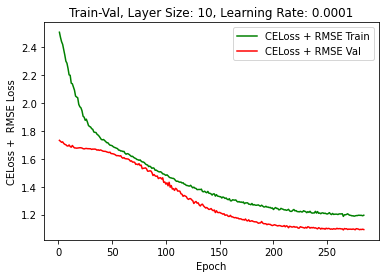

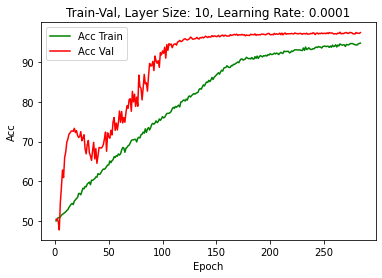

Part_Number_1_model_lr_0.0001_layer_size_10.pt Was saved successfully 			[saved]
234
Total: 		 0.031016
Trainable: 		 0.031016
////////////////////////
 Learning Rate:  0.001000 
 Layer Size:     10.00
 ////////////////////////
Epochs 1   Counter 1   Tr(CELoss): 0.99934   Vl(CELoss): 0.65870   Tr(ACC):   51.31905   Vl(ACC):   64.15238 Tr(RMSE):  1.49499   Vl(RMSE):  1.02761   Tr(Total): 2.49433   Vl(Total): 1.68631

Epochs 2   Counter 1   Tr(CELoss): 0.83602   Vl(CELoss): 0.64828   Tr(ACC):   53.53810   Vl(ACC):   68.60953 Tr(RMSE):  1.32071   Vl(RMSE):  1.01278   Tr(Total): 2.15673   Vl(Total): 1.66106

Epochs 3   Counter 1   Tr(CELoss): 0.74011   Vl(CELoss): 0.65324   Tr(ACC):   55.59048   Vl(ACC):   64.89524 Tr(RMSE):  1.19231   Vl(RMSE):  1.00779   Tr(Total): 1.93242   Vl(Total): 1.66103

Epochs 4   Counter 1   Tr(CELoss): 0.68650   Vl(CELoss): 0.64459   Tr(ACC):   57.34762   Vl(ACC):   66.13333 Tr(RMSE):  1.11661   Vl(RMSE):  1.00488   Tr(Total): 1.80311   Vl(Total): 1.64946

Epoc

Epochs 43   Counter 5   Tr(CELoss): 0.19008   Vl(CELoss): 0.12365   Tr(ACC):   94.85714   Vl(ACC):   96.96190 Tr(RMSE):  0.99831   Vl(RMSE):  0.99315   Tr(Total): 1.18840   Vl(Total): 1.11679

Epochs 44   Counter 1   Tr(CELoss): 0.19247   Vl(CELoss): 0.11281   Tr(ACC):   94.76667   Vl(ACC):   97.23810 Tr(RMSE):  0.99801   Vl(RMSE):  0.99182   Tr(Total): 1.19047   Vl(Total): 1.10463

Epochs 45   Counter 1   Tr(CELoss): 0.19296   Vl(CELoss): 0.10622   Tr(ACC):   94.78095   Vl(ACC):   97.27619 Tr(RMSE):  0.99720   Vl(RMSE):  0.99236   Tr(Total): 1.19016   Vl(Total): 1.09858

Epochs 46   Counter 2   Tr(CELoss): 0.18654   Vl(CELoss): 0.10979   Tr(ACC):   94.76191   Vl(ACC):   97.14286 Tr(RMSE):  0.99754   Vl(RMSE):  0.99234   Tr(Total): 1.18408   Vl(Total): 1.10213

Epochs 47   Counter 3   Tr(CELoss): 0.19259   Vl(CELoss): 0.11399   Tr(ACC):   94.62857   Vl(ACC):   97.14286 Tr(RMSE):  0.99824   Vl(RMSE):  0.99121   Tr(Total): 1.19083   Vl(Total): 1.10521

Epochs 48   Counter 4   Tr(CELoss):

Epochs 86   Counter 10   Tr(CELoss): 0.16125   Vl(CELoss): 0.09835   Tr(ACC):   95.16191   Vl(ACC):   97.38095 Tr(RMSE):  0.99048   Vl(RMSE):  0.97626   Tr(Total): 1.15174   Vl(Total): 1.07461

Epochs 87   Counter 11   Tr(CELoss): 0.15919   Vl(CELoss): 0.09385   Tr(ACC):   95.05714   Vl(ACC):   97.38095 Tr(RMSE):  0.98905   Vl(RMSE):  0.97667   Tr(Total): 1.14824   Vl(Total): 1.07052

Epochs 88   Counter 1   Tr(CELoss): 0.16427   Vl(CELoss): 0.08839   Tr(ACC):   95.20476   Vl(ACC):   97.38095 Tr(RMSE):  0.98891   Vl(RMSE):  0.97666   Tr(Total): 1.15317   Vl(Total): 1.06504

Epochs 89   Counter 2   Tr(CELoss): 0.16040   Vl(CELoss): 0.09820   Tr(ACC):   95.20000   Vl(ACC):   97.47619 Tr(RMSE):  0.99009   Vl(RMSE):  0.97584   Tr(Total): 1.15049   Vl(Total): 1.07403

Epochs 90   Counter 3   Tr(CELoss): 0.16496   Vl(CELoss): 0.09051   Tr(ACC):   95.13810   Vl(ACC):   97.47619 Tr(RMSE):  0.98921   Vl(RMSE):  0.97631   Tr(Total): 1.15416   Vl(Total): 1.06682

Epochs 91   Counter 4   Tr(CELoss

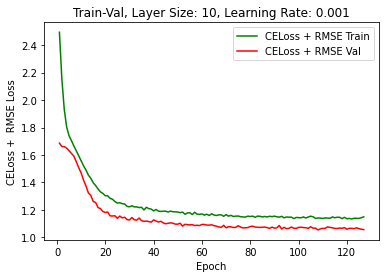

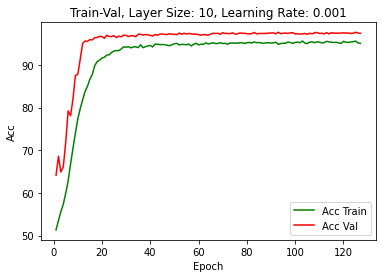

Part_Number_1_model_lr_0.001_layer_size_10.pt Was saved successfully 			[saved]
262
Total: 		 0.031016
Trainable: 		 0.031016
////////////////////////
 Learning Rate:  0.010000 
 Layer Size:     10.00
 ////////////////////////
Epochs 1   Counter 1   Tr(CELoss): 0.73745   Vl(CELoss): 0.68116   Tr(ACC):   52.99524   Vl(ACC):   62.61905 Tr(RMSE):  1.13782   Vl(RMSE):  0.99869   Tr(Total): 1.87527   Vl(Total): 1.67986

Epochs 2   Counter 1   Tr(CELoss): 0.64666   Vl(CELoss): 0.51214   Tr(ACC):   68.08095   Vl(ACC):   88.59048 Tr(RMSE):  1.00649   Vl(RMSE):  0.99351   Tr(Total): 1.65315   Vl(Total): 1.50564

Epochs 3   Counter 1   Tr(CELoss): 0.43315   Vl(CELoss): 0.24963   Tr(ACC):   85.60000   Vl(ACC):   94.99048 Tr(RMSE):  1.01278   Vl(RMSE):  0.99618   Tr(Total): 1.44593   Vl(Total): 1.24582

Epochs 4   Counter 1   Tr(CELoss): 0.30487   Vl(CELoss): 0.19079   Tr(ACC):   90.43810   Vl(ACC):   95.84762 Tr(RMSE):  1.00585   Vl(RMSE):  0.99751   Tr(Total): 1.31072   Vl(Total): 1.18830

Epoch

Epochs 43   Counter 6   Tr(CELoss): 0.16431   Vl(CELoss): 0.11733   Tr(ACC):   95.26190   Vl(ACC):   97.47619 Tr(RMSE):  1.00098   Vl(RMSE):  0.99495   Tr(Total): 1.16529   Vl(Total): 1.11228

Epochs 44   Counter 7   Tr(CELoss): 0.15550   Vl(CELoss): 0.10846   Tr(ACC):   95.39524   Vl(ACC):   97.57143 Tr(RMSE):  1.00083   Vl(RMSE):  0.99470   Tr(Total): 1.15633   Vl(Total): 1.10317

Epochs 45   Counter 1   Tr(CELoss): 0.15347   Vl(CELoss): 0.10692   Tr(ACC):   95.54762   Vl(ACC):   97.38095 Tr(RMSE):  1.00136   Vl(RMSE):  0.99500   Tr(Total): 1.15483   Vl(Total): 1.10192

Epochs 46   Counter 2   Tr(CELoss): 0.15111   Vl(CELoss): 0.10863   Tr(ACC):   95.66667   Vl(ACC):   97.28571 Tr(RMSE):  1.00101   Vl(RMSE):  0.99592   Tr(Total): 1.15212   Vl(Total): 1.10454

Epochs 47   Counter 1   Tr(CELoss): 0.16376   Vl(CELoss): 0.10441   Tr(ACC):   95.35714   Vl(ACC):   97.38095 Tr(RMSE):  1.00187   Vl(RMSE):  0.99571   Tr(Total): 1.16564   Vl(Total): 1.10012

Epochs 48   Counter 2   Tr(CELoss):

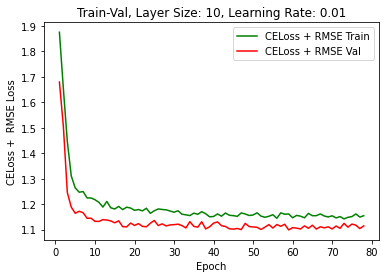

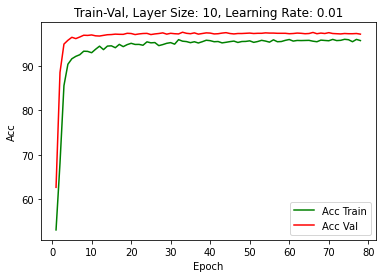

Part_Number_1_model_lr_0.01_layer_size_10.pt Was saved successfully 			[saved]
0
CV part number:	 2
Total: 		 0.031016
Trainable: 		 0.031016
////////////////////////
 Learning Rate:  0.000100 
 Layer Size:     10.00
 ////////////////////////
Epochs 1   Counter 1   Tr(CELoss): 0.93009   Vl(CELoss): 0.70013   Tr(ACC):   50.22857   Vl(ACC):   50.24762 Tr(RMSE):  1.57649   Vl(RMSE):  1.02827   Tr(Total): 2.50658   Vl(Total): 1.72840

Epochs 2   Counter 1   Tr(CELoss): 0.92166   Vl(CELoss): 0.69586   Tr(ACC):   50.64286   Vl(ACC):   49.40952 Tr(RMSE):  1.56164   Vl(RMSE):  1.02921   Tr(Total): 2.48331   Vl(Total): 1.72507

Epochs 3   Counter 1   Tr(CELoss): 0.90203   Vl(CELoss): 0.69518   Tr(ACC):   50.64286   Vl(ACC):   50.14286 Tr(RMSE):  1.54020   Vl(RMSE):  1.02923   Tr(Total): 2.44223   Vl(Total): 1.72441

Epochs 4   Counter 1   Tr(CELoss): 0.89326   Vl(CELoss): 0.68770   Tr(ACC):   51.21905   Vl(ACC):   49.15238 Tr(RMSE):  1.52878   Vl(RMSE):  1.02975   Tr(Total): 2.42205   Vl(Total)

Epochs 43   Counter 1   Tr(CELoss): 0.63908   Vl(CELoss): 0.65184   Tr(ACC):   62.75714   Vl(ACC):   67.21905 Tr(RMSE):  1.08678   Vl(RMSE):  1.00525   Tr(Total): 1.72585   Vl(Total): 1.65708

Epochs 44   Counter 1   Tr(CELoss): 0.63496   Vl(CELoss): 0.64596   Tr(ACC):   63.54762   Vl(ACC):   70.01905 Tr(RMSE):  1.08440   Vl(RMSE):  1.00594   Tr(Total): 1.71936   Vl(Total): 1.65191

Epochs 45   Counter 2   Tr(CELoss): 0.63405   Vl(CELoss): 0.64918   Tr(ACC):   63.32857   Vl(ACC):   67.59048 Tr(RMSE):  1.08205   Vl(RMSE):  1.00502   Tr(Total): 1.71610   Vl(Total): 1.65420

Epochs 46   Counter 1   Tr(CELoss): 0.63182   Vl(CELoss): 0.64761   Tr(ACC):   63.79524   Vl(ACC):   68.89524 Tr(RMSE):  1.07717   Vl(RMSE):  1.00224   Tr(Total): 1.70899   Vl(Total): 1.64984

Epochs 47   Counter 2   Tr(CELoss): 0.62993   Vl(CELoss): 0.64919   Tr(ACC):   63.86191   Vl(ACC):   66.94286 Tr(RMSE):  1.07664   Vl(RMSE):  1.00361   Tr(Total): 1.70657   Vl(Total): 1.65280

Epochs 48   Counter 3   Tr(CELoss):

Epochs 98   Counter 1   Tr(CELoss): 0.46939   Vl(CELoss): 0.47258   Tr(ACC):   75.68572   Vl(ACC):   87.96191 Tr(RMSE):  1.02475   Vl(RMSE):  0.99784   Tr(Total): 1.49414   Vl(Total): 1.47042

Epochs 99   Counter 1   Tr(CELoss): 0.46840   Vl(CELoss): 0.46915   Tr(ACC):   75.67143   Vl(ACC):   88.09524 Tr(RMSE):  1.02034   Vl(RMSE):  0.99767   Tr(Total): 1.48874   Vl(Total): 1.46682

Epochs 100   Counter 1   Tr(CELoss): 0.45996   Vl(CELoss): 0.44914   Tr(ACC):   76.46191   Vl(ACC):   90.64762 Tr(RMSE):  1.02013   Vl(RMSE):  0.99765   Tr(Total): 1.48009   Vl(Total): 1.44680

Epochs 101   Counter 2   Tr(CELoss): 0.46293   Vl(CELoss): 0.48143   Tr(ACC):   76.11905   Vl(ACC):   85.52381 Tr(RMSE):  1.02123   Vl(RMSE):  0.99915   Tr(Total): 1.48416   Vl(Total): 1.48058

Epochs 102   Counter 1   Tr(CELoss): 0.45279   Vl(CELoss): 0.44017   Tr(ACC):   76.69524   Vl(ACC):   90.66667 Tr(RMSE):  1.02279   Vl(RMSE):  0.99740   Tr(Total): 1.47558   Vl(Total): 1.43757

Epochs 103   Counter 2   Tr(CELo

Epochs 141   Counter 3   Tr(CELoss): 0.35598   Vl(CELoss): 0.27825   Tr(ACC):   84.18572   Vl(ACC):   95.54286 Tr(RMSE):  1.00579   Vl(RMSE):  0.99571   Tr(Total): 1.36176   Vl(Total): 1.27395

Epochs 142   Counter 4   Tr(CELoss): 0.35353   Vl(CELoss): 0.27620   Tr(ACC):   84.17143   Vl(ACC):   95.48571 Tr(RMSE):  1.00537   Vl(RMSE):  0.99505   Tr(Total): 1.35891   Vl(Total): 1.27125

Epochs 143   Counter 1   Tr(CELoss): 0.34385   Vl(CELoss): 0.27492   Tr(ACC):   84.92381   Vl(ACC):   95.18095 Tr(RMSE):  1.00560   Vl(RMSE):  0.99509   Tr(Total): 1.34944   Vl(Total): 1.27001

Epochs 144   Counter 1   Tr(CELoss): 0.34832   Vl(CELoss): 0.26267   Tr(ACC):   85.00000   Vl(ACC):   95.69524 Tr(RMSE):  1.00543   Vl(RMSE):  0.99471   Tr(Total): 1.35375   Vl(Total): 1.25738

Epochs 145   Counter 2   Tr(CELoss): 0.34385   Vl(CELoss): 0.27490   Tr(ACC):   85.76191   Vl(ACC):   95.28572 Tr(RMSE):  1.00672   Vl(RMSE):  0.99519   Tr(Total): 1.35058   Vl(Total): 1.27009

Epochs 146   Counter 1   Tr(CE

Epochs 184   Counter 2   Tr(CELoss): 0.28987   Vl(CELoss): 0.18520   Tr(ACC):   90.89524   Vl(ACC):   96.34286 Tr(RMSE):  0.99960   Vl(RMSE):  0.99407   Tr(Total): 1.28947   Vl(Total): 1.17927

Epochs 185   Counter 1   Tr(CELoss): 0.28345   Vl(CELoss): 0.17092   Tr(ACC):   90.91429   Vl(ACC):   96.99048 Tr(RMSE):  1.00012   Vl(RMSE):  0.99352   Tr(Total): 1.28357   Vl(Total): 1.16444

Epochs 186   Counter 2   Tr(CELoss): 0.28324   Vl(CELoss): 0.17097   Tr(ACC):   91.12381   Vl(ACC):   96.98095 Tr(RMSE):  0.99955   Vl(RMSE):  0.99357   Tr(Total): 1.28279   Vl(Total): 1.16454

Epochs 187   Counter 3   Tr(CELoss): 0.27816   Vl(CELoss): 0.17194   Tr(ACC):   91.51429   Vl(ACC):   97.04762 Tr(RMSE):  0.99843   Vl(RMSE):  0.99345   Tr(Total): 1.27659   Vl(Total): 1.16539

Epochs 188   Counter 1   Tr(CELoss): 0.28685   Vl(CELoss): 0.16670   Tr(ACC):   91.27619   Vl(ACC):   96.93333 Tr(RMSE):  0.99982   Vl(RMSE):  0.99298   Tr(Total): 1.28667   Vl(Total): 1.15968

Epochs 189   Counter 2   Tr(CE

Epochs 227   Counter 1   Tr(CELoss): 0.23567   Vl(CELoss): 0.12726   Tr(ACC):   93.31905   Vl(ACC):   97.31429 Tr(RMSE):  0.99522   Vl(RMSE):  0.99015   Tr(Total): 1.23089   Vl(Total): 1.11741

Epochs 228   Counter 2   Tr(CELoss): 0.24030   Vl(CELoss): 0.12940   Tr(ACC):   93.41905   Vl(ACC):   97.14286 Tr(RMSE):  0.99562   Vl(RMSE):  0.99029   Tr(Total): 1.23591   Vl(Total): 1.11969

Epochs 229   Counter 3   Tr(CELoss): 0.23875   Vl(CELoss): 0.12892   Tr(ACC):   93.16667   Vl(ACC):   97.14286 Tr(RMSE):  0.99517   Vl(RMSE):  0.98978   Tr(Total): 1.23391   Vl(Total): 1.11870

Epochs 230   Counter 4   Tr(CELoss): 0.24010   Vl(CELoss): 0.13584   Tr(ACC):   93.18572   Vl(ACC):   96.75238 Tr(RMSE):  0.99535   Vl(RMSE):  0.99021   Tr(Total): 1.23545   Vl(Total): 1.12605

Epochs 231   Counter 5   Tr(CELoss): 0.23889   Vl(CELoss): 0.12888   Tr(ACC):   93.32381   Vl(ACC):   97.20000 Tr(RMSE):  0.99481   Vl(RMSE):  0.99007   Tr(Total): 1.23370   Vl(Total): 1.11895

Epochs 232   Counter 1   Tr(CE

Epochs 270   Counter 6   Tr(CELoss): 0.20601   Vl(CELoss): 0.12280   Tr(ACC):   94.51905   Vl(ACC):   96.99048 Tr(RMSE):  0.99380   Vl(RMSE):  0.98823   Tr(Total): 1.19982   Vl(Total): 1.11103

Epochs 271   Counter 1   Tr(CELoss): 0.21189   Vl(CELoss): 0.11087   Tr(ACC):   94.43333   Vl(ACC):   97.29524 Tr(RMSE):  0.99350   Vl(RMSE):  0.98688   Tr(Total): 1.20539   Vl(Total): 1.09776

Epochs 272   Counter 2   Tr(CELoss): 0.21831   Vl(CELoss): 0.11779   Tr(ACC):   94.22857   Vl(ACC):   97.23810 Tr(RMSE):  0.99358   Vl(RMSE):  0.98820   Tr(Total): 1.21189   Vl(Total): 1.10600

Epochs 273   Counter 1   Tr(CELoss): 0.21452   Vl(CELoss): 0.10797   Tr(ACC):   94.38572   Vl(ACC):   97.47619 Tr(RMSE):  0.99344   Vl(RMSE):  0.98767   Tr(Total): 1.20796   Vl(Total): 1.09564

Epochs 274   Counter 2   Tr(CELoss): 0.21270   Vl(CELoss): 0.11641   Tr(ACC):   94.50000   Vl(ACC):   97.19048 Tr(RMSE):  0.99369   Vl(RMSE):  0.98792   Tr(Total): 1.20639   Vl(Total): 1.10433

Epochs 275   Counter 3   Tr(CE

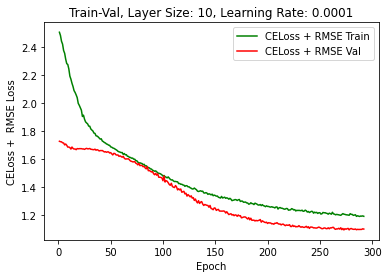

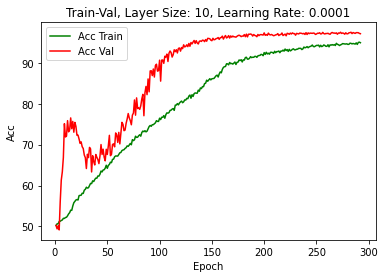

Part_Number_2_model_lr_0.0001_layer_size_10.pt Was saved successfully 			[saved]
252
Total: 		 0.031016
Trainable: 		 0.031016
////////////////////////
 Learning Rate:  0.001000 
 Layer Size:     10.00
 ////////////////////////
Epochs 1   Counter 1   Tr(CELoss): 0.93459   Vl(CELoss): 0.65807   Tr(ACC):   51.63333   Vl(ACC):   57.41905 Tr(RMSE):  1.41346   Vl(RMSE):  1.02237   Tr(Total): 2.34804   Vl(Total): 1.68044

Epochs 2   Counter 1   Tr(CELoss): 0.79627   Vl(CELoss): 0.67458   Tr(ACC):   53.56191   Vl(ACC):   52.52381 Tr(RMSE):  1.20261   Vl(RMSE):  1.00147   Tr(Total): 1.99888   Vl(Total): 1.67605

Epochs 3   Counter 1   Tr(CELoss): 0.73513   Vl(CELoss): 0.66704   Tr(ACC):   54.48572   Vl(ACC):   66.16191 Tr(RMSE):  1.10145   Vl(RMSE):  0.99697   Tr(Total): 1.83658   Vl(Total): 1.66401

Epochs 4   Counter 1   Tr(CELoss): 0.69950   Vl(CELoss): 0.65554   Tr(ACC):   56.43810   Vl(ACC):   65.60000 Tr(RMSE):  1.05515   Vl(RMSE):  0.99733   Tr(Total): 1.75465   Vl(Total): 1.65287

Epoc

Epochs 43   Counter 6   Tr(CELoss): 0.20310   Vl(CELoss): 0.12893   Tr(ACC):   94.87143   Vl(ACC):   97.03810 Tr(RMSE):  0.99914   Vl(RMSE):  0.99885   Tr(Total): 1.20224   Vl(Total): 1.12778

Epochs 44   Counter 1   Tr(CELoss): 0.20896   Vl(CELoss): 0.12380   Tr(ACC):   94.87143   Vl(ACC):   97.28571 Tr(RMSE):  0.99837   Vl(RMSE):  0.99871   Tr(Total): 1.20733   Vl(Total): 1.12252

Epochs 45   Counter 1   Tr(CELoss): 0.20563   Vl(CELoss): 0.11377   Tr(ACC):   94.64762   Vl(ACC):   97.38095 Tr(RMSE):  0.99935   Vl(RMSE):  0.99868   Tr(Total): 1.20499   Vl(Total): 1.11245

Epochs 46   Counter 2   Tr(CELoss): 0.20639   Vl(CELoss): 0.12695   Tr(ACC):   94.70476   Vl(ACC):   96.99048 Tr(RMSE):  0.99894   Vl(RMSE):  0.99859   Tr(Total): 1.20533   Vl(Total): 1.12554

Epochs 47   Counter 1   Tr(CELoss): 0.20416   Vl(CELoss): 0.10581   Tr(ACC):   94.74762   Vl(ACC):   97.64762 Tr(RMSE):  0.99870   Vl(RMSE):  0.99781   Tr(Total): 1.20286   Vl(Total): 1.10362

Epochs 48   Counter 2   Tr(CELoss):

Epochs 86   Counter 5   Tr(CELoss): 0.16969   Vl(CELoss): 0.08608   Tr(ACC):   95.65714   Vl(ACC):   97.61905 Tr(RMSE):  0.99173   Vl(RMSE):  0.98366   Tr(Total): 1.16142   Vl(Total): 1.06974

Epochs 87   Counter 6   Tr(CELoss): 0.16794   Vl(CELoss): 0.09072   Tr(ACC):   95.63333   Vl(ACC):   97.52381 Tr(RMSE):  0.99166   Vl(RMSE):  0.98441   Tr(Total): 1.15960   Vl(Total): 1.07513

Epochs 88   Counter 7   Tr(CELoss): 0.17084   Vl(CELoss): 0.08144   Tr(ACC):   95.50952   Vl(ACC):   97.71429 Tr(RMSE):  0.99056   Vl(RMSE):  0.98436   Tr(Total): 1.16141   Vl(Total): 1.06580

Epochs 89   Counter 8   Tr(CELoss): 0.18019   Vl(CELoss): 0.08613   Tr(ACC):   95.60476   Vl(ACC):   97.66667 Tr(RMSE):  0.99233   Vl(RMSE):  0.98305   Tr(Total): 1.17252   Vl(Total): 1.06917

Epochs 90   Counter 9   Tr(CELoss): 0.17508   Vl(CELoss): 0.08958   Tr(ACC):   95.55714   Vl(ACC):   97.47619 Tr(RMSE):  0.99095   Vl(RMSE):  0.98323   Tr(Total): 1.16603   Vl(Total): 1.07282

Epochs 91   Counter 1   Tr(CELoss):

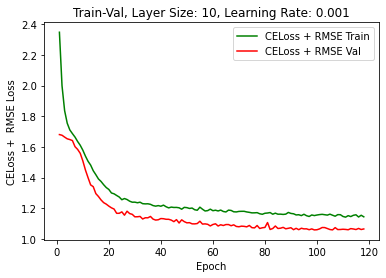

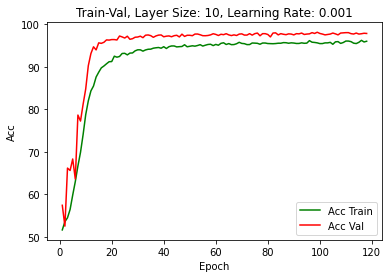

Part_Number_2_model_lr_0.001_layer_size_10.pt Was saved successfully 			[saved]
256
Total: 		 0.031016
Trainable: 		 0.031016
////////////////////////
 Learning Rate:  0.010000 
 Layer Size:     10.00
 ////////////////////////
Epochs 1   Counter 1   Tr(CELoss): 0.70459   Vl(CELoss): 0.61305   Tr(ACC):   54.63810   Vl(ACC):   76.75238 Tr(RMSE):  1.15415   Vl(RMSE):  0.99805   Tr(Total): 1.85874   Vl(Total): 1.61110

Epochs 2   Counter 1   Tr(CELoss): 0.55853   Vl(CELoss): 0.27146   Tr(ACC):   70.92381   Vl(ACC):   93.95238 Tr(RMSE):  1.00700   Vl(RMSE):  0.99374   Tr(Total): 1.56554   Vl(Total): 1.26520

Epochs 3   Counter 1   Tr(CELoss): 0.35051   Vl(CELoss): 0.18274   Tr(ACC):   85.78572   Vl(ACC):   94.34286 Tr(RMSE):  1.00650   Vl(RMSE):  0.99748   Tr(Total): 1.35700   Vl(Total): 1.18022

Epochs 4   Counter 1   Tr(CELoss): 0.26536   Vl(CELoss): 0.13088   Tr(ACC):   89.00953   Vl(ACC):   96.00000 Tr(RMSE):  1.00089   Vl(RMSE):  0.99290   Tr(Total): 1.26626   Vl(Total): 1.12378

Epoch

Epochs 43   Counter 5   Tr(CELoss): 0.15626   Vl(CELoss): 0.07844   Tr(ACC):   95.09524   Vl(ACC):   97.57143 Tr(RMSE):  0.98641   Vl(RMSE):  0.97060   Tr(Total): 1.14267   Vl(Total): 1.04904

Epochs 44   Counter 6   Tr(CELoss): 0.16373   Vl(CELoss): 0.09288   Tr(ACC):   95.04762   Vl(ACC):   97.14286 Tr(RMSE):  0.98487   Vl(RMSE):  0.96439   Tr(Total): 1.14860   Vl(Total): 1.05727

Epochs 45   Counter 7   Tr(CELoss): 0.15949   Vl(CELoss): 0.07854   Tr(ACC):   94.91905   Vl(ACC):   97.52381 Tr(RMSE):  0.98559   Vl(RMSE):  0.97191   Tr(Total): 1.14508   Vl(Total): 1.05045

Epochs 46   Counter 8   Tr(CELoss): 0.15522   Vl(CELoss): 0.08933   Tr(ACC):   95.02857   Vl(ACC):   97.23810 Tr(RMSE):  0.98490   Vl(RMSE):  0.96986   Tr(Total): 1.14011   Vl(Total): 1.05919

Epochs 47   Counter 9   Tr(CELoss): 0.15822   Vl(CELoss): 0.07892   Tr(ACC):   94.88095   Vl(ACC):   97.71429 Tr(RMSE):  0.98424   Vl(RMSE):  0.96947   Tr(Total): 1.14246   Vl(Total): 1.04838

Epochs 48   Counter 10   Tr(CELoss)

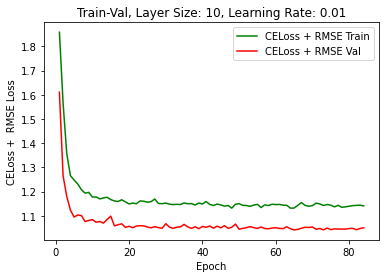

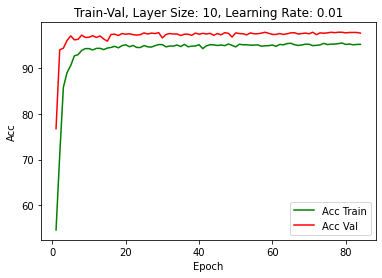

Part_Number_2_model_lr_0.01_layer_size_10.pt Was saved successfully 			[saved]
265
CV part number:	 3
Total: 		 0.031016
Trainable: 		 0.031016
////////////////////////
 Learning Rate:  0.000100 
 Layer Size:     10.00
 ////////////////////////
Epochs 1   Counter 1   Tr(CELoss): 0.93325   Vl(CELoss): 0.69761   Tr(ACC):   50.56667   Vl(ACC):   49.50476 Tr(RMSE):  1.56508   Vl(RMSE):  1.03395   Tr(Total): 2.49833   Vl(Total): 1.73156

Epochs 2   Counter 1   Tr(CELoss): 0.92060   Vl(CELoss): 0.69428   Tr(ACC):   50.78572   Vl(ACC):   48.69524 Tr(RMSE):  1.54779   Vl(RMSE):  1.02868   Tr(Total): 2.46839   Vl(Total): 1.72296

Epochs 3   Counter 2   Tr(CELoss): 0.90227   Vl(CELoss): 0.69466   Tr(ACC):   50.66667   Vl(ACC):   48.49524 Tr(RMSE):  1.53965   Vl(RMSE):  1.02896   Tr(Total): 2.44192   Vl(Total): 1.72362

Epochs 4   Counter 1   Tr(CELoss): 0.89048   Vl(CELoss): 0.68539   Tr(ACC):   51.07619   Vl(ACC):   48.20952 Tr(RMSE):  1.51768   Vl(RMSE):  1.03323   Tr(Total): 2.40816   Vl(Tota

Epochs 43   Counter 2   Tr(CELoss): 0.64279   Vl(CELoss): 0.65373   Tr(ACC):   61.83810   Vl(ACC):   65.63810 Tr(RMSE):  1.08782   Vl(RMSE):  1.00584   Tr(Total): 1.73060   Vl(Total): 1.65957

Epochs 44   Counter 3   Tr(CELoss): 0.63788   Vl(CELoss): 0.64957   Tr(ACC):   63.07619   Vl(ACC):   70.99048 Tr(RMSE):  1.07748   Vl(RMSE):  1.00707   Tr(Total): 1.71535   Vl(Total): 1.65664

Epochs 45   Counter 4   Tr(CELoss): 0.63824   Vl(CELoss): 0.64867   Tr(ACC):   62.46667   Vl(ACC):   70.56191 Tr(RMSE):  1.07911   Vl(RMSE):  1.00824   Tr(Total): 1.71735   Vl(Total): 1.65691

Epochs 46   Counter 5   Tr(CELoss): 0.63432   Vl(CELoss): 0.65158   Tr(ACC):   63.09048   Vl(ACC):   67.27619 Tr(RMSE):  1.07885   Vl(RMSE):  1.00481   Tr(Total): 1.71317   Vl(Total): 1.65640

Epochs 47   Counter 6   Tr(CELoss): 0.63348   Vl(CELoss): 0.65283   Tr(ACC):   63.09048   Vl(ACC):   64.26667 Tr(RMSE):  1.07700   Vl(RMSE):  1.00525   Tr(Total): 1.71048   Vl(Total): 1.65808

Epochs 48   Counter 1   Tr(CELoss):

Epochs 86   Counter 1   Tr(CELoss): 0.50995   Vl(CELoss): 0.51442   Tr(ACC):   73.20476   Vl(ACC):   85.50476 Tr(RMSE):  1.02770   Vl(RMSE):  1.00027   Tr(Total): 1.53765   Vl(Total): 1.51469

Epochs 87   Counter 1   Tr(CELoss): 0.51501   Vl(CELoss): 0.50526   Tr(ACC):   72.61905   Vl(ACC):   88.17143 Tr(RMSE):  1.02727   Vl(RMSE):  1.00023   Tr(Total): 1.54228   Vl(Total): 1.50549

Epochs 88   Counter 1   Tr(CELoss): 0.50833   Vl(CELoss): 0.48387   Tr(ACC):   72.59048   Vl(ACC):   90.72381 Tr(RMSE):  1.02809   Vl(RMSE):  1.00089   Tr(Total): 1.53642   Vl(Total): 1.48476

Epochs 89   Counter 2   Tr(CELoss): 0.50095   Vl(CELoss): 0.48545   Tr(ACC):   73.44762   Vl(ACC):   90.50476 Tr(RMSE):  1.02364   Vl(RMSE):  0.99989   Tr(Total): 1.52459   Vl(Total): 1.48534

Epochs 90   Counter 3   Tr(CELoss): 0.49831   Vl(CELoss): 0.49483   Tr(ACC):   73.76191   Vl(ACC):   87.05714 Tr(RMSE):  1.02491   Vl(RMSE):  0.99939   Tr(Total): 1.52322   Vl(Total): 1.49421

Epochs 91   Counter 1   Tr(CELoss):

Epochs 129   Counter 2   Tr(CELoss): 0.37351   Vl(CELoss): 0.30014   Tr(ACC):   81.94762   Vl(ACC):   95.67619 Tr(RMSE):  1.00679   Vl(RMSE):  0.99808   Tr(Total): 1.38030   Vl(Total): 1.29822

Epochs 130   Counter 1   Tr(CELoss): 0.38068   Vl(CELoss): 0.27939   Tr(ACC):   81.13333   Vl(ACC):   96.28571 Tr(RMSE):  1.00730   Vl(RMSE):  0.99803   Tr(Total): 1.38797   Vl(Total): 1.27742

Epochs 131   Counter 2   Tr(CELoss): 0.37174   Vl(CELoss): 0.28066   Tr(ACC):   81.84762   Vl(ACC):   96.14286 Tr(RMSE):  1.00739   Vl(RMSE):  0.99825   Tr(Total): 1.37913   Vl(Total): 1.27891

Epochs 132   Counter 1   Tr(CELoss): 0.37608   Vl(CELoss): 0.27581   Tr(ACC):   81.82381   Vl(ACC):   96.17143 Tr(RMSE):  1.00722   Vl(RMSE):  0.99801   Tr(Total): 1.38330   Vl(Total): 1.27383

Epochs 133   Counter 1   Tr(CELoss): 0.36934   Vl(CELoss): 0.26792   Tr(ACC):   82.12857   Vl(ACC):   96.42857 Tr(RMSE):  1.00707   Vl(RMSE):  0.99774   Tr(Total): 1.37641   Vl(Total): 1.26566

Epochs 134   Counter 2   Tr(CE

Epochs 172   Counter 1   Tr(CELoss): 0.29044   Vl(CELoss): 0.16007   Tr(ACC):   89.69524   Vl(ACC):   97.10476 Tr(RMSE):  1.00176   Vl(RMSE):  0.99764   Tr(Total): 1.29219   Vl(Total): 1.15771

Epochs 173   Counter 2   Tr(CELoss): 0.29796   Vl(CELoss): 0.16765   Tr(ACC):   89.86667   Vl(ACC):   96.83810 Tr(RMSE):  1.00029   Vl(RMSE):  0.99797   Tr(Total): 1.29825   Vl(Total): 1.16562

Epochs 174   Counter 3   Tr(CELoss): 0.27938   Vl(CELoss): 0.16549   Tr(ACC):   90.22381   Vl(ACC):   97.04762 Tr(RMSE):  1.00197   Vl(RMSE):  0.99805   Tr(Total): 1.28134   Vl(Total): 1.16354

Epochs 175   Counter 1   Tr(CELoss): 0.28904   Vl(CELoss): 0.15066   Tr(ACC):   90.33810   Vl(ACC):   97.20000 Tr(RMSE):  1.00145   Vl(RMSE):  0.99738   Tr(Total): 1.29048   Vl(Total): 1.14804

Epochs 176   Counter 2   Tr(CELoss): 0.28160   Vl(CELoss): 0.15492   Tr(ACC):   90.39524   Vl(ACC):   97.24762 Tr(RMSE):  1.00136   Vl(RMSE):  0.99833   Tr(Total): 1.28297   Vl(Total): 1.15325

Epochs 177   Counter 3   Tr(CE

Epochs 215   Counter 5   Tr(CELoss): 0.24740   Vl(CELoss): 0.11780   Tr(ACC):   91.69524   Vl(ACC):   97.20000 Tr(RMSE):  0.99548   Vl(RMSE):  0.99660   Tr(Total): 1.24288   Vl(Total): 1.11439

Epochs 216   Counter 6   Tr(CELoss): 0.23890   Vl(CELoss): 0.11582   Tr(ACC):   91.94762   Vl(ACC):   97.28571 Tr(RMSE):  0.99560   Vl(RMSE):  0.99585   Tr(Total): 1.23450   Vl(Total): 1.11166

Epochs 217   Counter 7   Tr(CELoss): 0.24163   Vl(CELoss): 0.12003   Tr(ACC):   92.46191   Vl(ACC):   97.36190 Tr(RMSE):  0.99597   Vl(RMSE):  0.99652   Tr(Total): 1.23759   Vl(Total): 1.11655

Epochs 218   Counter 8   Tr(CELoss): 0.23850   Vl(CELoss): 0.11884   Tr(ACC):   92.56191   Vl(ACC):   97.18095 Tr(RMSE):  0.99619   Vl(RMSE):  0.99596   Tr(Total): 1.23469   Vl(Total): 1.11480

Epochs 219   Counter 9   Tr(CELoss): 0.23532   Vl(CELoss): 0.12139   Tr(ACC):   92.23810   Vl(ACC):   97.12381 Tr(RMSE):  0.99597   Vl(RMSE):  0.99632   Tr(Total): 1.23130   Vl(Total): 1.11771

Epochs 220   Counter 1   Tr(CE

Epochs 258   Counter 2   Tr(CELoss): 0.21146   Vl(CELoss): 0.10006   Tr(ACC):   93.77143   Vl(ACC):   97.66667 Tr(RMSE):  0.99235   Vl(RMSE):  0.99303   Tr(Total): 1.20381   Vl(Total): 1.09308

Epochs 259   Counter 3   Tr(CELoss): 0.21592   Vl(CELoss): 0.10279   Tr(ACC):   93.44762   Vl(ACC):   97.51429 Tr(RMSE):  0.99368   Vl(RMSE):  0.99289   Tr(Total): 1.20960   Vl(Total): 1.09569

Epochs 260   Counter 4   Tr(CELoss): 0.20946   Vl(CELoss): 0.10420   Tr(ACC):   93.80476   Vl(ACC):   97.47619 Tr(RMSE):  0.99295   Vl(RMSE):  0.99288   Tr(Total): 1.20241   Vl(Total): 1.09708

Epochs 261   Counter 5   Tr(CELoss): 0.21340   Vl(CELoss): 0.09995   Tr(ACC):   93.80000   Vl(ACC):   97.40000 Tr(RMSE):  0.99360   Vl(RMSE):  0.99256   Tr(Total): 1.20700   Vl(Total): 1.09252

Epochs 262   Counter 6   Tr(CELoss): 0.21986   Vl(CELoss): 0.10402   Tr(ACC):   93.24762   Vl(ACC):   97.32381 Tr(RMSE):  0.99289   Vl(RMSE):  0.99172   Tr(Total): 1.21274   Vl(Total): 1.09574

Epochs 263   Counter 7   Tr(CE

Epochs 301   Counter 6   Tr(CELoss): 0.20039   Vl(CELoss): 0.09791   Tr(ACC):   94.59048   Vl(ACC):   97.49524 Tr(RMSE):  0.99044   Vl(RMSE):  0.98902   Tr(Total): 1.19083   Vl(Total): 1.08693

Epochs 302   Counter 7   Tr(CELoss): 0.19675   Vl(CELoss): 0.09469   Tr(ACC):   94.52857   Vl(ACC):   97.60952 Tr(RMSE):  0.99083   Vl(RMSE):  0.98851   Tr(Total): 1.18758   Vl(Total): 1.08320

Epochs 303   Counter 8   Tr(CELoss): 0.19754   Vl(CELoss): 0.09563   Tr(ACC):   94.82381   Vl(ACC):   97.76190 Tr(RMSE):  0.99067   Vl(RMSE):  0.98909   Tr(Total): 1.18820   Vl(Total): 1.08472

Epochs 304   Counter 1   Tr(CELoss): 0.20415   Vl(CELoss): 0.09071   Tr(ACC):   94.40476   Vl(ACC):   97.85714 Tr(RMSE):  0.99189   Vl(RMSE):  0.98906   Tr(Total): 1.19605   Vl(Total): 1.07976

Epochs 305   Counter 2   Tr(CELoss): 0.20241   Vl(CELoss): 0.09196   Tr(ACC):   94.67619   Vl(ACC):   97.95238 Tr(RMSE):  0.99085   Vl(RMSE):  0.98859   Tr(Total): 1.19326   Vl(Total): 1.08055

Epochs 306   Counter 3   Tr(CE

Epochs 344   Counter 10   Tr(CELoss): 0.18996   Vl(CELoss): 0.09317   Tr(ACC):   95.08095   Vl(ACC):   97.79048 Tr(RMSE):  0.98920   Vl(RMSE):  0.98713   Tr(Total): 1.17916   Vl(Total): 1.08030

Epochs 345   Counter 11   Tr(CELoss): 0.18455   Vl(CELoss): 0.09466   Tr(ACC):   95.00476   Vl(ACC):   97.73333 Tr(RMSE):  0.98921   Vl(RMSE):  0.98746   Tr(Total): 1.17376   Vl(Total): 1.08212

Epochs 346   Counter 12   Tr(CELoss): 0.18260   Vl(CELoss): 0.09333   Tr(ACC):   94.84762   Vl(ACC):   97.78095 Tr(RMSE):  0.98941   Vl(RMSE):  0.98707   Tr(Total): 1.17201   Vl(Total): 1.08040

Epochs 347   Counter 13   Tr(CELoss): 0.19059   Vl(CELoss): 0.08987   Tr(ACC):   94.90000   Vl(ACC):   97.85714 Tr(RMSE):  0.98858   Vl(RMSE):  0.98718   Tr(Total): 1.17917   Vl(Total): 1.07705

Epochs 348   Counter 14   Tr(CELoss): 0.18758   Vl(CELoss): 0.09363   Tr(ACC):   94.86191   Vl(ACC):   97.66667 Tr(RMSE):  0.98935   Vl(RMSE):  0.98703   Tr(Total): 1.17693   Vl(Total): 1.08066

Epochs 349   Counter 15  

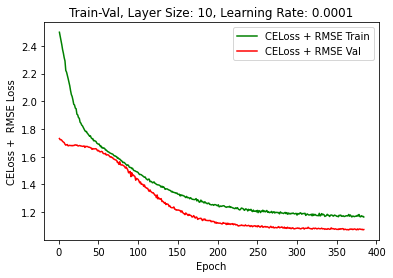

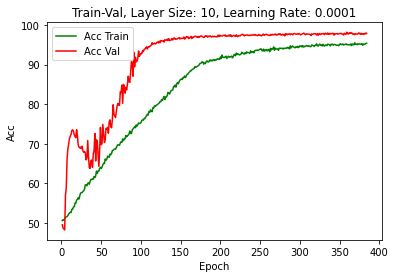

Part_Number_3_model_lr_0.0001_layer_size_10.pt Was saved successfully 			[saved]
249
Total: 		 0.031016
Trainable: 		 0.031016
////////////////////////
 Learning Rate:  0.001000 
 Layer Size:     10.00
 ////////////////////////
Epochs 1   Counter 1   Tr(CELoss): 0.89496   Vl(CELoss): 0.65648   Tr(ACC):   51.05714   Vl(ACC):   70.20953 Tr(RMSE):  1.72806   Vl(RMSE):  1.04431   Tr(Total): 2.62302   Vl(Total): 1.70079

Epochs 2   Counter 1   Tr(CELoss): 0.78025   Vl(CELoss): 0.62778   Tr(ACC):   53.20952   Vl(ACC):   76.37143 Tr(RMSE):  1.46851   Vl(RMSE):  1.04103   Tr(Total): 2.24876   Vl(Total): 1.66881

Epochs 3   Counter 1   Tr(CELoss): 0.70631   Vl(CELoss): 0.59837   Tr(ACC):   56.15714   Vl(ACC):   77.73334 Tr(RMSE):  1.31521   Vl(RMSE):  1.03015   Tr(Total): 2.02152   Vl(Total): 1.62852

Epochs 4   Counter 1   Tr(CELoss): 0.66296   Vl(CELoss): 0.58942   Tr(ACC):   59.66191   Vl(ACC):   79.83810 Tr(RMSE):  1.21498   Vl(RMSE):  1.01968   Tr(Total): 1.87795   Vl(Total): 1.60910

Epoc

Epochs 43   Counter 3   Tr(CELoss): 0.20756   Vl(CELoss): 0.10500   Tr(ACC):   94.01905   Vl(ACC):   97.40952 Tr(RMSE):  0.99764   Vl(RMSE):  0.99932   Tr(Total): 1.20520   Vl(Total): 1.10431

Epochs 44   Counter 4   Tr(CELoss): 0.21338   Vl(CELoss): 0.10726   Tr(ACC):   93.86667   Vl(ACC):   97.46667 Tr(RMSE):  0.99761   Vl(RMSE):  0.99885   Tr(Total): 1.21099   Vl(Total): 1.10610

Epochs 45   Counter 1   Tr(CELoss): 0.19826   Vl(CELoss): 0.09488   Tr(ACC):   94.15714   Vl(ACC):   97.76190 Tr(RMSE):  0.99663   Vl(RMSE):  0.99856   Tr(Total): 1.19489   Vl(Total): 1.09344

Epochs 46   Counter 1   Tr(CELoss): 0.19928   Vl(CELoss): 0.09113   Tr(ACC):   94.36191   Vl(ACC):   97.79048 Tr(RMSE):  0.99659   Vl(RMSE):  0.99825   Tr(Total): 1.19587   Vl(Total): 1.08938

Epochs 47   Counter 2   Tr(CELoss): 0.19528   Vl(CELoss): 0.09196   Tr(ACC):   94.66191   Vl(ACC):   97.71429 Tr(RMSE):  0.99542   Vl(RMSE):  0.99745   Tr(Total): 1.19070   Vl(Total): 1.08941

Epochs 48   Counter 3   Tr(CELoss):

Epochs 86   Counter 2   Tr(CELoss): 0.17509   Vl(CELoss): 0.07252   Tr(ACC):   94.58571   Vl(ACC):   97.95238 Tr(RMSE):  0.98660   Vl(RMSE):  0.98412   Tr(Total): 1.16169   Vl(Total): 1.05664

Epochs 87   Counter 3   Tr(CELoss): 0.17633   Vl(CELoss): 0.07864   Tr(ACC):   94.51429   Vl(ACC):   97.71429 Tr(RMSE):  0.98629   Vl(RMSE):  0.97952   Tr(Total): 1.16262   Vl(Total): 1.05816

Epochs 88   Counter 4   Tr(CELoss): 0.16563   Vl(CELoss): 0.08498   Tr(ACC):   95.00476   Vl(ACC):   97.52381 Tr(RMSE):  0.98499   Vl(RMSE):  0.98074   Tr(Total): 1.15062   Vl(Total): 1.06572

Epochs 89   Counter 5   Tr(CELoss): 0.17116   Vl(CELoss): 0.07706   Tr(ACC):   94.49048   Vl(ACC):   97.61905 Tr(RMSE):  0.98572   Vl(RMSE):  0.97971   Tr(Total): 1.15688   Vl(Total): 1.05677

Epochs 90   Counter 6   Tr(CELoss): 0.16654   Vl(CELoss): 0.07980   Tr(ACC):   94.94286   Vl(ACC):   97.66667 Tr(RMSE):  0.98445   Vl(RMSE):  0.98004   Tr(Total): 1.15098   Vl(Total): 1.05985

Epochs 91   Counter 7   Tr(CELoss):

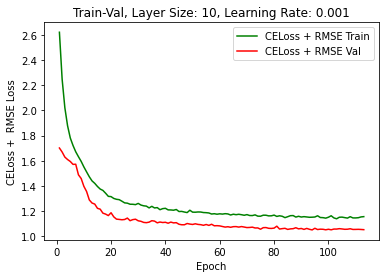

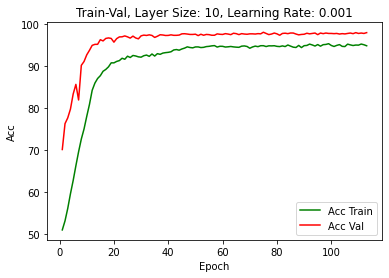

Part_Number_3_model_lr_0.001_layer_size_10.pt Was saved successfully 			[saved]
257
Total: 		 0.031016
Trainable: 		 0.031016
////////////////////////
 Learning Rate:  0.010000 
 Layer Size:     10.00
 ////////////////////////
Epochs 1   Counter 1   Tr(CELoss): 0.71147   Vl(CELoss): 0.67139   Tr(ACC):   55.97619   Vl(ACC):   61.19048 Tr(RMSE):  1.10683   Vl(RMSE):  1.00321   Tr(Total): 1.81830   Vl(Total): 1.67460

Epochs 2   Counter 1   Tr(CELoss): 0.53864   Vl(CELoss): 0.31194   Tr(ACC):   73.53810   Vl(ACC):   91.49524 Tr(RMSE):  1.01395   Vl(RMSE):  1.00143   Tr(Total): 1.55259   Vl(Total): 1.31337

Epochs 3   Counter 1   Tr(CELoss): 0.34232   Vl(CELoss): 0.14755   Tr(ACC):   86.33810   Vl(ACC):   96.15238 Tr(RMSE):  1.00461   Vl(RMSE):  0.99559   Tr(Total): 1.34693   Vl(Total): 1.14314

Epochs 4   Counter 1   Tr(CELoss): 0.26845   Vl(CELoss): 0.12011   Tr(ACC):   90.42857   Vl(ACC):   96.57143 Tr(RMSE):  0.99833   Vl(RMSE):  0.99598   Tr(Total): 1.26678   Vl(Total): 1.11610

Epoch

Epochs 43   Counter 11   Tr(CELoss): 0.16769   Vl(CELoss): 0.07297   Tr(ACC):   95.08095   Vl(ACC):   97.85714 Tr(RMSE):  0.98529   Vl(RMSE):  0.97837   Tr(Total): 1.15298   Vl(Total): 1.05134

Epochs 44   Counter 12   Tr(CELoss): 0.15608   Vl(CELoss): 0.07387   Tr(ACC):   95.33810   Vl(ACC):   97.85714 Tr(RMSE):  0.98415   Vl(RMSE):  0.97482   Tr(Total): 1.14023   Vl(Total): 1.04869

Epochs 45   Counter 13   Tr(CELoss): 0.16622   Vl(CELoss): 0.07203   Tr(ACC):   94.51905   Vl(ACC):   97.90476 Tr(RMSE):  0.98220   Vl(RMSE):  0.97732   Tr(Total): 1.14842   Vl(Total): 1.04934

Epochs 46   Counter 14   Tr(CELoss): 0.16410   Vl(CELoss): 0.07061   Tr(ACC):   94.95238   Vl(ACC):   97.85714 Tr(RMSE):  0.98497   Vl(RMSE):  0.97833   Tr(Total): 1.14907   Vl(Total): 1.04895

Epochs 47   Counter 15   Tr(CELoss): 0.16106   Vl(CELoss): 0.07519   Tr(ACC):   94.92857   Vl(ACC):   98.00000 Tr(RMSE):  0.98487   Vl(RMSE):  0.97772   Tr(Total): 1.14594   Vl(Total): 1.05291

Epochs 48   Counter 16   Tr(CE

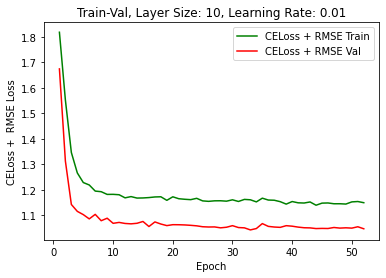

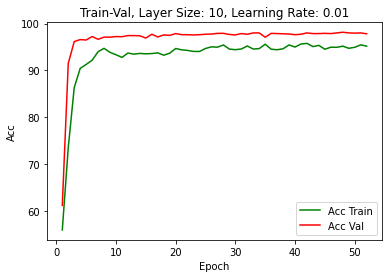

Part_Number_3_model_lr_0.01_layer_size_10.pt Was saved successfully 			[saved]
260


In [116]:
if __name__ == '__main__':
    parser = argparse.ArgumentParser()

    parser.add_argument('--epochs', default = 800, type = int,
                        help='Number of epochs for training')
    parser.add_argument('--stopping_criterion', default=20, type = int,
                        help='N iterations of non-improving validation score until early stopping')
    parser.add_argument('--batch_size', default = 256, type = int,
                        help='Batch size used for training')
    parser.add_argument('--device', type = str, default=("cpu" if not torch.cuda.is_available() else "cuda"),
                        help="Device: CPU or GPU on which training is conducted")
    parser.add_argument('--seed', default = 17, type=int,
                        help='Seed to reproduce the results')
    parser.add_argument('--n_splits', default = 3, type = int,
                        help = 'Number of pars for training in K-Fold cross-validations')
    parser.add_argument('--parts', type = list, default = np.arange(1,11),
                        help = 'Parts which we want consider. By default: all 10 parts of partition. See "n_splits"')

    args = parser.parse_args("")

    main(args)

In [115]:
%ls

Data/                     Element_based_data/      element_agnostic.ipynb*
Data_100_500nm/           Results/                 element_and_h.ipynb
Data_40k/                 Results_Images/          element_based.ipynb*
Data_normal_with_6/       Results_Images_Element/  tester/
Data_normal_with_6_last/  Untitled.ipynb*
Data_uniform/             aaa.csv*


In [114]:
!rm -rf ./Results_element/

In [583]:
model_test = torch.load('./Results_element/Part_Number_1/Part_Number_1_lr_0.0001_layer_size_10/Part_Number_1_model_lr_0.0001_layer_size_10.pt')

In [584]:
model = NeuralNetwork(100).to(device)

In [585]:
model.load_state_dict(model_test)

<All keys matched successfully>

In [586]:
model.eval()

NeuralNetwork(
  (layer_1): Linear(in_features=151, out_features=100, bias=True)
  (layer_2): Linear(in_features=100, out_features=64, bias=True)
  (layer_3): Linear(in_features=64, out_features=64, bias=True)
  (layer_4): Linear(in_features=64, out_features=32, bias=True)
  (layer_5): Linear(in_features=32, out_features=10, bias=True)
  (layer_out_1): Linear(in_features=10, out_features=2, bias=True)
  (layer_out_2): Linear(in_features=10, out_features=2, bias=True)
  (layer_out_3): Linear(in_features=10, out_features=2, bias=True)
  (layer_out_4): Linear(in_features=10, out_features=2, bias=True)
  (layer_out_5): Linear(in_features=10, out_features=2, bias=True)
  (layer_out_6): Linear(in_features=10, out_features=6, bias=True)
  (relu): LeakyReLU(negative_slope=0.1)
  (dropout): Dropout(p=0.6, inplace=False)
  (batchnorm1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

In [605]:
a, b, c = increase(model)

In [606]:
b

array([[ 0.53783375,  0.46550643,  0.5341538 ,  0.49676087,  0.4852377 ,
         0.49055082],
       [ 0.5570149 ,  0.47163087,  0.5407597 ,  0.5018282 ,  0.49009302,
         0.4928628 ],
       [ 0.5761863 ,  0.47775358,  0.5473624 ,  0.5068935 ,  0.4949464 ,
         0.49518153],
       ...,
       [13.884293  ,  4.7218204 ,  5.1279507 ,  4.0218215 ,  3.860476  ,
         2.1147385 ],
       [13.903464  ,  4.7279344 ,  5.1345496 ,  4.0268855 ,  3.865325  ,
         2.1170716 ],
       [13.922644  ,  4.7340503 ,  5.1411505 ,  4.0319514 ,  3.870175  ,
         2.1194048 ]], dtype=float32)

In [607]:
a

array([[1, 0, 1, 0, 1],
       [1, 0, 1, 0, 1],
       [1, 0, 1, 0, 1],
       ...,
       [1, 0, 1, 0, 1],
       [1, 0, 1, 0, 1],
       [1, 0, 1, 0, 1]])

In [608]:
c

array([  1. ,   1.5,   2. ,   2.5,   3. ,   3.5,   4. ,   4.5,   5. ,
         5.5,   6. ,   6.5,   7. ,   7.5,   8. ,   8.5,   9. ,   9.5,
        10. ,  10.5,  11. ,  11.5,  12. ,  12.5,  13. ,  13.5,  14. ,
        14.5,  15. ,  15.5,  16. ,  16.5,  17. ,  17.5,  18. ,  18.5,
        19. ,  19.5,  20. ,  20.5,  21. ,  21.5,  22. ,  22.5,  23. ,
        23.5,  24. ,  24.5,  25. ,  25.5,  26. ,  26.5,  27. ,  27.5,
        28. ,  28.5,  29. ,  29.5,  30. ,  30.5,  31. ,  31.5,  32. ,
        32.5,  33. ,  33.5,  34. ,  34.5,  35. ,  35.5,  36. ,  36.5,
        37. ,  37.5,  38. ,  38.5,  39. ,  39.5,  40. ,  40.5,  41. ,
        41.5,  42. ,  42.5,  43. ,  43.5,  44. ,  44.5,  45. ,  45.5,
        46. ,  46.5,  47. ,  47.5,  48. ,  48.5,  49. ,  49.5,  50. ,
        50.5,  51. ,  51.5,  52. ,  52.5,  53. ,  53.5,  54. ,  54.5,
        55. ,  55.5,  56. ,  56.5,  57. ,  57.5,  58. ,  58.5,  59. ,
        59.5,  60. ,  60.5,  61. ,  61.5,  62. ,  62.5,  63. ,  63.5,
        64. ,  64.5,

In [264]:
a.shape

(699, 5)

In [265]:
a

array([[1., 0., 1., 0., 1.],
       [1., 0., 1., 0., 1.],
       [1., 0., 1., 0., 1.],
       ...,
       [1., 0., 1., 0., 1.],
       [1., 0., 1., 0., 1.],
       [1., 0., 1., 0., 1.]], dtype=float32)

In [196]:
b

[1,
 1.5,
 2.0,
 2.5,
 3.0,
 3.5,
 4.0,
 4.5,
 5.0,
 5.5,
 6.0,
 6.5,
 7.0,
 7.5,
 8.0,
 8.5,
 9.0,
 9.5,
 10.0,
 10.5,
 11.0,
 11.5,
 12.0,
 12.5,
 13.0,
 13.5,
 14.0,
 14.5,
 15.0,
 15.5,
 16.0,
 16.5,
 17.0,
 17.5,
 18.0,
 18.5,
 19.0,
 19.5,
 20.0,
 20.5,
 21.0,
 21.5,
 22.0,
 22.5,
 23.0,
 23.5,
 24.0,
 24.5,
 25.0,
 25.5,
 26.0,
 26.5,
 27.0,
 27.5,
 28.0,
 28.5,
 29.0,
 29.5,
 30.0,
 30.5,
 31.0,
 31.5,
 32.0,
 32.5,
 33.0,
 33.5,
 34.0,
 34.5,
 35.0,
 35.5,
 36.0,
 36.5,
 37.0,
 37.5,
 38.0,
 38.5,
 39.0,
 39.5,
 40.0,
 40.5,
 41.0,
 41.5,
 42.0,
 42.5,
 43.0,
 43.5,
 44.0,
 44.5,
 45.0,
 45.5,
 46.0,
 46.5,
 47.0,
 47.5,
 48.0,
 48.5,
 49.0,
 49.5,
 50.0,
 50.5,
 51.0,
 51.5,
 52.0,
 52.5,
 53.0,
 53.5,
 54.0,
 54.5,
 55.0,
 55.5,
 56.0,
 56.5,
 57.0,
 57.5,
 58.0,
 58.5,
 59.0,
 59.5,
 60.0,
 60.5,
 61.0,
 61.5,
 62.0,
 62.5,
 63.0,
 63.5,
 64.0,
 64.5,
 65.0,
 65.5,
 66.0,
 66.5,
 67.0,
 67.5,
 68.0,
 68.5,
 69.0,
 69.5,
 70.0,
 70.5,
 71.0,
 71.5,
 72.0,
 72.5,
 73.0,
 73.5